In [1]:
import time
import numpy as np
import scipy
from opt_einsum import contract as einsum
import pyscf
from pyscf import gto, scf, dft, tddft, data, lib
from pyscf.prop.polarizability.rhf import Polarizability
import argparse
import os
import psutil
import yaml
from pyscf.tools import molden
from pyscf.dft import xcfun


print('curpath', os.getcwd())
print('lib.num_threads() = ', lib.num_threads())

parser = argparse.ArgumentParser(description='Davidson')
parser.add_argument('-x', '--xyzfile',        type=str, default='NA', help='xyz filename (molecule.xyz)')
# parser.add_argument('-chk', '--checkfile',    type=str, default='NA', help='checkpoint filename (.chk)')
parser.add_argument('-m', '--method',         type=str, default='RKS', help='RHF RKS UHF UKS')
parser.add_argument('-f', '--functional',     type=str, default='pbe0', help='xc functional')
parser.add_argument('-b', '--basis_set',      type=str, default='def2-svp', help='basis set')
parser.add_argument('-df', '--density_fit',   type=bool, default=True, help='density fitting turn on')
parser.add_argument('-g', '--grid_level',     type=int, default='3', help='0-9, 9 is best')
# parser.add_argument('-i', '--initial_guess',  type=str, default='sTDA', help='initial guess: Adiag or sTDA')
# parser.add_argument('-p', '--preconditioner', type=str, default='sTDA', help='preconditioner: Adiag or sTDA')
parser.add_argument('-t',  '--tolerance',      type=float, default= 1e-5, help='residual norm convergence threshold')
parser.add_argument('-n',  '--nstates',        type=int, default= 4, help='number of excited states')
parser.add_argument('-C',  '--compare',        type=bool, default = False , help='whether to compare with PySCF TDA-TDDFT')
parser.add_argument('-TDA','--TDA',          type=bool, default = False,  help='use TDA')
parser.add_argument('-RPA','--RPA',          type=bool, default = False,   help='use RPA')
parser.add_argument('-o',  '--options',        type=int, default = [0], nargs='+', help='0-7')
parser.add_argument('-oo', '--RPAoptions',    type=int, default = [0], nargs='+', help='0-4')
parser.add_argument('-it', '--initialTOL',    type=float, default= 1e-4, help='convergence threshold for sTDA inital guess')
parser.add_argument('-pt', '--precondTOL',    type=float, default= 1e-5, help='convergence threshold for sTDA preconditioner')
parser.add_argument('-M',  '--memory',        type=int, default= 4000, help='max_memory')
parser.add_argument('-ei', '--extrainitial',  type=int, default= 8, help='number of extral initial guess vectors, 0-8')
parser.add_argument('-et', '--eigensolver_tol',type=float, default= 1e-5, help='convergence threshold for new guess generator in new_ES')
args = parser.parse_args()
################################################

curpath /Users/zehaozhou/Desktop/project/davidson/davidson
lib.num_threads() =  1


In [2]:
args = parser.parse_args(args=['--tolerance', '1e-5',  '--nstates', '4', '--functional', 'pbe0'])
print(args)

Namespace(RPA=False, RPAoptions=[0], TDA=False, basis_set='def2-svp', compare=False, density_fit=True, eigensolver_tol=1e-05, extrainitial=8, functional='pbe0', grid_level=3, initialTOL=0.0001, memory=4000, method='RKS', nstates=4, options=[0], precondTOL=1e-05, tolerance=1e-05, xyzfile='NA')


In [3]:
mol = gto.Mole()
mol.build(atom = '\
C         -4.89126        3.29770        0.00029;\
O         -3.49307        3.28429       -0.00328;\
H         -5.28213        2.58374        0.75736;\
H         -5.28213        3.05494       -1.01161;\
H         -5.23998        4.31540        0.27138;\
H         -3.22959        2.35981       -0.24953',\
basis = 'def2-SVP')

In [4]:
mol.verbose = 5
mf = dft.RKS(mol) 

mf.conv_tol = 1e-10
mf.grids.level = 3     # 0-9, big number for large mesh grids, default is 3

mf = mf.density_fit()
mf.xc = 'pbe0'


kernel_0 = time.time()
mf.kernel()

kernel_1 = time.time()
kernel_t = kernel_1 - kernel_0
print ('SCF Done after ', round(kernel_t, 4), 'seconds')



******** <class 'pyscf.df.df_jk.density_fit.<locals>.DFHF'> ********
method = DFHF-RKS-RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-10
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /var/folders/yv/2d0zlq3j1dq04l1tjz4qgg800000gn/T/tmpag_e47mv
max_memory 4000 MB (current use 0 MB)
XC functionals = pbe0
small_rho_cutoff = 1e-07
radial grids: 
    Treutler-Ahlrichs [JCP 102, 346 (1995); DOI:10.1063/1.469408] (M4) radial grids
    
becke partition: Becke, JCP 88, 2547 (1988); DOI:10.1063/1.454033
pruning grids: <function nwchem_prune at 0x7feb9c9fbf80>
grids dens level: 3
symmetrized grids: False
atomic radii adjust function: <function treutler_atomic_radii_adjust at 0x7feb9c9fbef0>
Set gradient conv threshold to 1e-05
atom C rad-grids = 75, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  5

E1 = -236.9736008057559  Ecoul = 96.48440861976071  Exc = -15.353058254963372
cycle= 5 E= -115.496874558717  delta_E= -4.64e-05  |g|= 0.00336  |ddm|= 0.0137
    CPU time for cycle= 5      0.23 sec, wall time      0.12 sec
  HOMO = -0.275849564670619  LUMO = 0.0615480733024131
  mo_energy =
[-19.19994046 -10.27249498  -1.02713675  -0.68191987  -0.513148
  -0.45199093  -0.43476771  -0.33721223  -0.27584956   0.06154807
   0.10803363   0.14751629   0.14843656   0.20840399   0.4706443
   0.48817859   0.49887208   0.59363618   0.6580324    0.67089434
   0.68510983   0.72331483   0.96710349   0.97237381   1.03332233
   1.23194649   1.31476576   1.46042673   1.47814292   1.5231682
   1.56310766   1.71490552   1.77023065   1.82714304   1.88557986
   1.98753477   2.15157473   2.2112369    2.33076862   2.3661324
   2.65897106   2.80634373   2.83353552   2.95773895   3.07523111
   3.18141625   3.31782836   3.74865807]
nelec by numeric integration = 18.000001764571905
    CPU time for vxc      0.2

In [5]:
mo_coeff = mf.mo_coeff
mo_occ = mf.mo_occ
# spolar_vind = Polarizability(mf).gen_vind(mf, mo_coeff, mo_occ)


In [6]:
print(Polarizability(mf).polarizability())
#     [[16.77324762 -1.38494423 -0.36897545]
#      [-1.38494423 16.67651601  0.49281976]
#      [-0.36897545  0.49281976 14.95748124]]

    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
krylov cycle 0  r = 1.37899
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
krylov cycle 1  r = 0.79006
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
krylov cycle 2  r = 0.164444
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
krylov cycle 3  r = 0.0697994
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
krylov cycle 4  r = 0.0204357
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
krylov cycle 5  r = 0.00303286
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
krylov cycle 6  r = 0.000579049
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
krylov cycle 7  r = 0.00011499
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
krylov cycle 8  r = 1.79249e-05
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
krylov cycle 9  r = 2.81996e-06
    CPU

In [7]:
# print(Polarizability(mf).polarizability_with_freq(freq= 0.08564543)) 
# freq= 0.08564543 in uit hartree, 532nm
#[[17.14813998 -1.41238856 -0.37629144]
# [-1.41238856 17.08174136  0.49171248]
 #[-0.37629144  0.49171248 15.36655666]]

In [8]:
# mo_coeff = mf.mo_coeff
# mo_occ = mf.mo_occ
# occidx = mo_occ > 0
# orbo = mo_coeff[:, occidx]
# orbv = mo_coeff[:,~occidx]
# int_r= mol.intor_symmetric('int1e_r')

In [9]:
# P = lib.einsum('xpq,pi,qa->xia', int_r, orbo, orbv.conj())
# # x=3, 3 directions?
# print(P.shape)

In [10]:
# a = [4,7,1]
# b = np.zeros([9])
# k = len(a)

In [11]:
# for jj in range(k):
#     print(a[jj])
#     b[3*jj : 3*(jj+1)] = a[jj]
# print(b)

In [12]:
# a = np.array([[10, 20],  
# [10, 20],  
# [10, 20],  
# [30, 40],  
# [30, 40]]) 
# b = np.repeat(a,3,axis=0)
# print(b)

In [13]:
# c =  np.tile(a,3)
# print(c)

In [14]:
a = np.eye(3)
print(a)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [15]:
b = a[:,:0]
print(b)

[]


In [16]:
c = np.array([1,2,3]).reshape(3,1)
d = np.dot(b.T,c)
print(d.shape)

(0, 1)


In [17]:
# print(Polarizability(mf).polarizability())
# print(Polarizability(mf).polarizability_with_freq(freq= 0.))

In [18]:
########################################################
def show_memory_info(hint):
    pid = os.getpid()
    p = psutil.Process(pid)
    info = p.memory_full_info()
    memory = info.uss / 1024 / 1024
    print('{} memory used: {} MB'.format(hint, memory))
########################################################

info = psutil.virtual_memory()
print(info)

show_memory_info('at beginning')


# # read xyz file and delete its first two lines
# basename = args.xyzfile.split('.',1)[0]

# f = open(args.xyzfile)
# atom_coordinates = f.readlines()
# del atom_coordinates[:2]
# ###########################################################################
# # build geometry in PySCF
# mol = gto.Mole()
# mol.atom = atom_coordinates
# mol.basis = args.basis_set
# mol.verbose = 3
# mol.max_memory = args.memory
# print('mol.max_memory', mol.max_memory)
# mol.build(parse_arg = False)
###########################################################################
###################################################
#DFT or HF?
if args.method == 'RKS':
    mf = dft.RKS(mol)
elif args.method == 'UKS':
    mf = dft.UKS(mol)
elif args.method == 'RHF':
    mf = scf.RHF(mol)
elif args.method == 'UHF':
    mf = scf.UHF(mol)

if 'KS' in args.method:
    print('RKS')
    mf.xc = args.functional
    mf.grids.level = args.grid_level
    # 0-9, big number for large mesh grids, default is 3
else:
    print('HF')

if args.density_fit:
    mf = mf.density_fit()
    print('Density fitting turned on')

# if args.checkfile != 'NA':
#     mf.chkfile = args.checkfile
#     mf.init_guess = 'chkfile'

mf.conv_tol = 1e-10


print ('Molecule built')
print ('Calculating SCF Energy...')
kernel_0 = time.time()
mf.kernel()
kernel_1 = time.time()
kernel_t = kernel_1 - kernel_0
print ('SCF Done after ', round(kernel_t, 4), 'seconds')

show_memory_info('after SCF')



#################################################################
# Collect everything needed from PySCF
Qstart = time.time()
Natm = mol.natm
mo_occ = mf.mo_occ
n_occ = len(np.where(mo_occ > 0)[0])
#mf.mo_occ is an array of occupance [2,2,2,2,2,0,0,0,0.....]
n_vir = len(np.where(mo_occ == 0)[0])
#################################################
# generate matrix vector multiplication function
td = tddft.TDA(mf)
TDA_vind, hdiag = td.gen_vind(mf)

TD = tddft.TDDFT(mf)
TDDFT_vind, Hdiag = TD.gen_vind(mf)



A_size = n_occ*n_vir

# return AV
def TDA_matrix_vector(V):
    '''return AV'''
    return TDA_vind(V.T).T

#return AX + BY and AY + BX
def TDDFT_matrix_vector(X, Y):
    '''return AX+BY and BX+AY'''
    XY = np.vstack((X,Y)).T
    U = TDDFT_vind(XY)
#     print('U.shape',U.shape)
    U1 = U[:,:A_size].T
    U2 = -U[:,A_size:].T
    return U1, U2
#################################################





N_bf = len(mo_occ)
R = pyscf.gto.mole.inter_distance(mol, coords=None)
#Inter-particle distance array
# unit == ’Bohr’, Its value is 5.29177210903(80)×10^(−11) m
##################################################################


##################################################################################################
# create a function for dictionary of chemical hardness, by mappig two iteratable subject, list
# list of elements

elements = ['H' , 'He', 'Li', 'Be', 'B' , 'C' , 'N' , 'O' , 'F' , 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P' , 'S' , 'Cl', 'Ar', 'K' , 'Ca','Sc', 'Ti', 'V' , 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn','Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y' , 'Zr','Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn','Sb', 'Te', 'I' , 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd','Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb','Lu', 'Hf', 'Ta', 'W' , 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg','Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U' , 'Np', 'Pu']
#list of chemical hardness, they are floats, containing elements 1-94, in Hartree
hardness = [0.47259288,0.92203391,0.17452888,0.25700733,0.33949086,0.42195412,0.50438193,0.58691863,0.66931351,0.75191607,0.17964105,0.22157276,0.26348578,0.30539645,0.34734014,0.38924725,0.43115670,0.47308269,0.17105469,0.20276244,0.21007322,0.21739647,0.22471039,0.23201501,0.23933969,0.24665638,0.25398255,0.26128863,0.26859476,0.27592565,0.30762999,0.33931580,0.37235985,0.40273549,0.43445776,0.46611708,0.15585079,0.18649324,0.19356210,0.20063311,0.20770522,0.21477254,0.22184614,0.22891872,0.23598621,0.24305612,0.25013018,0.25719937,0.28784780,0.31848673,0.34912431,0.37976593,0.41040808,0.44105777,0.05019332,0.06762570,0.08504445,0.10247736,0.11991105,0.13732772,0.15476297,0.17218265,0.18961288,0.20704760,0.22446752,0.24189645,0.25932503,0.27676094,0.29418231,0.31159587,0.32902274,0.34592298,0.36388048,0.38130586,0.39877476,0.41614298,0.43364510,0.45104014,0.46848986,0.48584550,0.12526730,0.14268677,0.16011615,0.17755889,0.19497557,0.21240778,0.07263525,0.09422158,0.09920295,0.10418621,0.14235633,0.16394294,0.18551941,0.22370139]
HARDNESS = dict(zip(elements,hardness))
#function to return chemical hardness from dictionary HARDNESS
def Hardness(atom_id):
    atom = mol.atom_pure_symbol(atom_id)
    return HARDNESS[atom]
# mol.atom_pure_symbol(atom_id) returns pure element symbol, no special characters


########################################################################
# This block is the function to produce orthonormalized coefficient matrix C
def matrix_power(S,a):
    s,ket = np.linalg.eigh(S)
    s = s**a
    X = np.linalg.multi_dot([ket,np.diag(s),ket.T])
    #X == S^1/2
    return X

def matrix_power2(S):
    s,ket = np.linalg.eigh(S)
    s_sqrt = s**0.5
    s_inv = 1/s_sqrt

    S1 = np.dot(ket*s_sqrt,ket.T)
    S2 = np.dot(ket*s_inv,ket.T)

    #S1 == S^1/2
    #S2 == S^-1/2
    return S1, S2

def orthonormalize(C):
    X = matrix_power(mf.get_ovlp(), 0.5)
    # S = mf.get_ovlp() #.get_ovlp() is basis overlap matrix
    # S = np.dot(np.linalg.inv(c.T), np.linalg.inv(c))
    C = np.dot(X,C)
    return C

C = mf.mo_coeff
# mf.mo_coeff is the coefficient matrix

C = orthonormalize(C)
# C is orthonormalized coefficient matrix
# np.dot(C.T,C) is a an identity matrix
########################################################################
RSH_F = [
'lc-b3lyp',
'wb97',
'wb97x',
'wb97x-d3',
'cam-b3lyp']
RSH_paramt = [
[0.53, 8.00, 4.50],
[0.61, 8.00, 4.41],
[0.56, 8.00, 4.58],
[0.51, 8.00, 4.51],
[0.38, 1.86, 0.90]]
RSH_F_paramt = dict(zip(RSH_F, RSH_paramt))

hybride_F = [
'b3lyp',
'tpssh',
'm05-2x',
'pbe0',
'm06',
'm06-2x',
'NA']# NA is for Hartree-Fork
hybride_paramt = [0.2, 0.1, 0.56, 0.25, 0.27, 0.54, 1]
DF_ax = dict(zip(hybride_F, hybride_paramt))
#Zhao, Y. and Truhlar, D.G., 2006. Density functional for spectroscopy: no long-range self-interaction error, good performance for Rydberg and charge-transfer states, and better performance on average than B3LYP for ground states. The Journal of Physical Chemistry A, 110(49), pp.13126-13130.

if args.functional in RSH_F:
    a_x, beta, alpha = RSH_F_paramt[args.functional]

elif args.functional in hybride_F:
    beta1 = 0.2
    beta2 = 1.83
    alpha1 = 1.42
    alpha2 = 0.48

    a_x = DF_ax[args.functional]
    beta = beta1 + beta2 * a_x
    alpha = alpha1 + alpha2 * a_x


# creat \eta matrix
a = [Hardness(atom_id) for atom_id in range(Natm)]
a = np.asarray(a).reshape(1,-1)
eta = (a+a.T)/2

# creat GammaK and GammaK matrix
GammaJ = (R**beta + (a_x * eta)**(-beta))**(-1/beta)
GammaK = (R**alpha + eta**(-alpha)) **(-1/alpha)


Natm = mol.natm
def generateQ():
    aoslice = mol.aoslice_by_atom()
    q = np.zeros([Natm, N_bf, N_bf])
    #N_bf is number Atomic orbitals, n_occ+n_vir, q is same size with C
    for atom_id in range(Natm):
        shst, shend, atstart, atend = aoslice[atom_id]
        q[atom_id,:, :] = np.dot(C[atstart:atend, :].T, C[atstart:atend, :])
    return q

q_tensors = generateQ()


q_tensor_ij = np.zeros((Natm, n_occ, n_occ))
q_tensor_ij[:,:,:] = q_tensors[:, :n_occ,:n_occ]

q_tensor_ab = np.zeros((Natm, n_vir, n_vir))
q_tensor_ab[:,:,:] = q_tensors[:, n_occ:,n_occ:]

q_tensor_ia = np.zeros((Natm, n_occ, n_vir))
q_tensor_ia[:,:,:] = q_tensors[:, :n_occ,n_occ:]


# del q_tensors
# gc.collect()
# print('q_tensors deleted')

Q_K = einsum('Bjb, AB -> Ajb', q_tensor_ia, GammaK)
Q_J = einsum('Bab, AB -> Aab', q_tensor_ab, GammaJ)
# pre-calculate and store the Q-Gamma rank 3 tensor
Qend = time.time()

Q_time = Qend - Qstart
print('Q-Gamma tensors building time =', round(Q_time, 4))
##################################################################################################

show_memory_info('after Q matrix')

###################################################################################################
# This block is to define on-the-fly two electron intergeral (pq|rs)
# A_iajb * v = delta_ia_ia*v + 2(ia|jb)*v - (ij|ab)*v

# iajb_v = einsum('Aia, Bjb, AB, jbm -> iam', q_tensor_ia, q_tensor_ia, GammaK, V)
# ijab_v = einsum('Aij, Bab, AB, jbm -> iam', q_tensor_ij, q_tensor_ab, GammaJ, V)

def iajb_fly(V):
    Q_K_V = einsum('Ajb, jbm -> Am', Q_K, V)
    iajb_V = einsum('Aia, Am -> iam', q_tensor_ia, Q_K_V).reshape(A_size, -1)
    return iajb_V

def ijab_fly(V):
    # contract larger index first
    Aab_V = einsum('Aab, jbm -> jAam', Q_J, V)
    #('Aab, mjb -> mjaA')
    ijab_V = einsum('Aij, jAam -> iam', q_tensor_ij, Aab_V).reshape(A_size, -1)
    #('Aij, mjaA -> mia)
    return ijab_V

def ibja_fly(V):
    # the Forck exchange energy in B matrix
    Q_K_V = einsum('Aja, jbm -> Aabm', Q_K, V)
    ibja_V = einsum('Aib, Aabm -> iam', q_tensor_ia, Q_K_V).reshape(A_size, -1)
    return ibja_V

delta_diag_A = hdiag.reshape(n_occ, n_vir)

def delta_fly(V):
    delta_v = einsum('ia,iam -> iam', delta_diag_A, V).reshape(A_size, -1)
    return delta_v

def sTDA_matrix_vector(V):
    # sTDA_A * V
    V = V.reshape(n_occ, n_vir, -1)
    # this feature can deal with multiple vectors
    AV =  delta_fly(V) + 2*iajb_fly(V) - ijab_fly(V)
    return AV

def sTDDFT_matrix_vector(X, Y):
    #return AX+BY and AY+BX
    X = X.reshape(n_occ, n_vir, -1)
    Y = Y.reshape(n_occ, n_vir, -1)

    iajb_X = 2*iajb_fly(X)
    iajb_Y = 2*iajb_fly(Y)

    #sTDA_A   = delta_fly(V) + 2*iajb_fly(V) - ijab_fly(V)
    #sTDDFT_B = 2*iajb_fly(V) - a_x*ibja_fly(V)

    AX = delta_fly(X) + iajb_X - ijab_fly(X)
    AY = delta_fly(Y) + iajb_Y - ijab_fly(Y)

    BX = iajb_X - a_x*ibja_fly(X)
    BY = iajb_Y - a_x*ibja_fly(Y)

    U1 = AX + BY
    U2 = AY + BX

    return U1, U2

def sTDDFT_static_polarizability_matrix_vector(X):
    '''return (A+B)X'''
    X = X.reshape(n_occ, n_vir, -1)
    U = delta_fly(X) + 4*iajb_fly(X) - ijab_fly(X) - a_x*ibja_fly(X)
    return U
###################################################################################################

svmem(total=8589934592, available=1973035008, percent=77.0, used=4690640896, free=82198528, active=1895489536, inactive=1814941696, wired=2795151360)
at beginning memory used: 86.81640625 MB
RKS
Density fitting turned on
Molecule built
Calculating SCF Energy...


******** <class 'pyscf.df.df_jk.density_fit.<locals>.DFHF'> ********
method = DFHF-RKS-RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-10
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /var/folders/yv/2d0zlq3j1dq04l1tjz4qgg800000gn/T/tmp9969os6k
max_memory 4000 MB (current use 0 MB)
XC functionals = pbe0
small_rho_cutoff = 1e-07
radial grids: 
    Treutler-Ahlrichs [JCP 102, 346 (1995); DOI:10.1063/1.469408] (M4) radial grids
    
becke partition: Becke, JCP 88, 2547 (1988); DOI:10.1063/1.454033
pruning grids: <function nwchem_prune at 0x7feb9c9fbf80

nelec by numeric integration = 18.000001764875766
    CPU time for vxc      0.26 sec, wall time      0.13 sec
    CPU time for df vj and vk      0.02 sec, wall time      0.01 sec
E1 = -236.9736008057559  Ecoul = 96.48440861976071  Exc = -15.353058254963372
cycle= 5 E= -115.496874558717  delta_E= -4.64e-05  |g|= 0.00336  |ddm|= 0.0137
    CPU time for cycle= 5      0.30 sec, wall time      0.15 sec
  HOMO = -0.275849564670619  LUMO = 0.0615480733024131
  mo_energy =
[-19.19994046 -10.27249498  -1.02713675  -0.68191987  -0.513148
  -0.45199093  -0.43476771  -0.33721223  -0.27584956   0.06154807
   0.10803363   0.14751629   0.14843656   0.20840399   0.4706443
   0.48817859   0.49887208   0.59363618   0.6580324    0.67089434
   0.68510983   0.72331483   0.96710349   0.97237381   1.03332233
   1.23194649   1.31476576   1.46042673   1.47814292   1.5231682
   1.56310766   1.71490552   1.77023065   1.82714304   1.88557986
   1.98753477   2.15157473   2.2112369    2.33076862   2.3661324
   2.65

In [19]:
import matplotlib.pyplot as plt
I = np.eye(A_size)
A = sTDA_matrix_vector(I)

In [20]:
w,u = np.linalg.eigh(A)

A_m_I = A - w[0]*I

A1 = TDA_matrix_vector(I)

    CPU time for df vj and vk      2.90 sec, wall time      1.48 sec


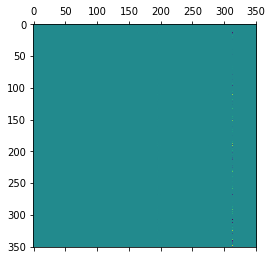

[[ 1.00000000e+00  0.00000000e+00 -8.30000000e-01 ... -1.67580000e+02
  -1.94570000e+02  1.48540000e+02]
 [ 0.00000000e+00  1.00000000e+00 -2.90000000e+00 ... -5.82670000e+02
  -6.76480000e+02  5.16450000e+02]
 [-8.26000000e+00 -8.30000000e-01  1.72181110e+05 ...  3.46358638e+07
   4.02126975e+07 -3.06997633e+07]
 ...
 [-7.31600000e+01 -7.31000000e+00  1.52413609e+06 ...  3.06596225e+08
   3.55962285e+08 -2.71753912e+08]
 [-9.25400000e+01 -9.24000000e+00  1.92800507e+06 ...  3.87838776e+08
   4.50285967e+08 -3.43763871e+08]
 [ 3.85000000e+01  3.85000000e+00 -8.02210850e+05 ... -1.61373265e+08
  -1.87356502e+08  1.43034431e+08]]
[ 1.00009190e+00  1.00041808e+00  1.72181105e+05  1.21367469e+00
  9.99063355e-01  9.99697463e-01 -1.66774707e+05  9.98998901e-01
  9.98777480e-01  9.99903991e-01 -4.06327735e+04  9.99284470e-01
  9.99726018e-01  9.99361225e-01  2.62175245e+05  9.99625210e-01
 -1.38236393e+05  9.99449121e-01  1.00022984e+00 -4.62976529e+04
 -3.97247183e+02  9.99967331e-01  2.336

In [21]:
# plt.matshow(A1)
# plt.show()
# print(w[0])
A_m_I = A - w[0]*I
# plt.matshow(A_m_I)
# plt.show()

A_m_I1 = A1 - w[0]*I


def matrix_power(S,a):
    s,ket = np.linalg.eig(S)
    s = s**a
    X = np.linalg.multi_dot([ket,np.diag(s),ket.T])
    #X == S^1/2
    return X


inv = matrix_power(A_m_I, -1)
# plt.matshow(inv)
# plt.show()

dot = np.dot(A_m_I1, inv)
plt.matshow(dot)
plt.show()
print(np.round(dot,2))
print(np.diag(dot))

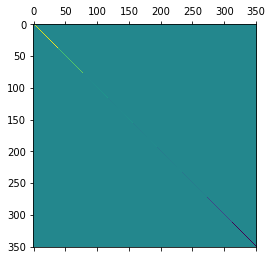

In [22]:
A_m_I = A - np.diag(w)
plt.matshow(A_m_I)
plt.show()

In [23]:
##############################################################################################
# orthonormalization of guess_vectors
def Gram_Schmidt_bvec(A, bvec):
    # suppose A is orthonormalized
    projections_coeff = np.dot(A.T, bvec)
    bvec = bvec - np.dot(A, projections_coeff)
    return bvec

def VW_Gram_Schmidt(x, y, V, W):

    m = np.dot(V.T,x) + np.dot(W.T,y)
    n = np.dot(W.T,x) + np.dot(V.T,y)

    x_new = x - np.dot(V,m) - np.dot(W,n)
    y_new = y - np.dot(W,m) - np.dot(V,n)

    return x_new, y_new

def Gram_Schmidt_fill_holder(V, count, vecs):
    # V is a vectors holder
    # count is the amount of vectors that already sit in the holder
    nvec = np.shape(vecs)[1]
    # amount of new vectors intended to fill in the V
    # count will be final amount of vectors in V
    for j in range(nvec):
        vec = vecs[:, j]
        vec = Gram_Schmidt_bvec(V[:, :count], vec)   #single orthonormalize
        vec = Gram_Schmidt_bvec(V[:, :count], vec) #double orthonormalize

        norm = np.linalg.norm(vec)
        if  norm > 1e-14:
            vec = vec/norm
            V[:, count] = vec
            count += 1
    new_count = count

    return V, new_count


def S_symmetry_orthogonal(x,y):

    S = np.zeros((2,2))
    S[0,0] = np.dot(x.T,x) + np.dot(y.T,y)
    S[0,1] = np.dot(x.T,y) + np.dot(y.T,x)
    S[1,0] = S[0,1]
    S[1,1] = S[0,0]

    ss = matrix_power(S, -0.5)
    a = ss[0,0]
    b = ss[0,1]
    # x = S^-1/2


    x_new = x*a + y*b
    y_new = y*a + x*b

    return x_new, y_new

def VW_Gram_Schmidt_fill_holder(V_holder, W_holder, m, X_new, Y_new):
    # put X_new into V, and Y_new into W
    # m is the amount of vectors that already on V or W

    nvec = np.shape(X_new)[1]
    # amount of new vectors intended to fill in the V_holder and W_holder
    for j in range(0, nvec):
        #x:=x−(VV+WW)x−(VW+WV)y
        #y:=y−(VV+WW)y−(VW+WV)x

        V = V_holder[:,:m]
        W = W_holder[:,:m]

        x_tmp = X_new[:,j].reshape(-1,1)
        y_tmp = Y_new[:,j].reshape(-1,1)

        x_tmp,y_tmp = VW_Gram_Schmidt(x_tmp, y_tmp, V, W)
        x_tmp,y_tmp = VW_Gram_Schmidt(x_tmp, y_tmp, V, W)

        x_tmp,y_tmp = S_symmetry_orthogonal(x_tmp,y_tmp)

        xy_norm = (np.dot(x_tmp.T, x_tmp) +  np.dot(y_tmp.T, y_tmp))**0.5

        if  xy_norm > 1e-14:
            x_tmp = x_tmp/xy_norm
            y_tmp = y_tmp/xy_norm

            V_holder[:,m] = x_tmp[:,0]
            W_holder[:,m] = y_tmp[:,0]

            m += 1
        else:
            print('vector kicked out during GS orthonormalization')
# XXX:
#     print('check VW orthonormalization')
#     VW = np.vstack((V_holder[:,:m], W_holder[:,:m]))
#     WV = np.vstack((W_holder[:,:m], V_holder[:,:m]))
#     VWWV = np.hstack((VW,WV))
#     print(check_orthonormal(VWWV))

    return V_holder, W_holder, m
########################################################################


####################################################################
# define the orthonormality of a matrix A as the norm of (A.T*A - I)
def check_orthonormal(A):
    n = np.shape(A)[1]
    B = np.dot(A.T, A)
    c = np.linalg.norm(B - np.eye(n))
    return c
####################################################################

########################################################################
def solve_AX_Xla_B(sub_A, eigen_lambda, sub_B):
    # AX - XB  = Q
    N_vectors = len(eigen_lambda)
    a, u = np.linalg.eigh(sub_A)
    ub = np.dot(u.T, sub_B)
    ux = np.zeros_like(sub_B)
    for k in range(N_vectors):
        ux[:, k] = ub[:, k]/(a - eigen_lambda[k])
    sub_guess = np.dot(u, ux)
    return sub_guess
#########################################################################

In [24]:
########################################################################
# sTDA preconditioner
def sTDA_preconditioner(arg1, arg2, arg3, arg4, arg5, arg6, arg7, arg8):
    """ residual[:,index], sub_eigenvalue[:k][index], current_dic, full_guess[:,index], index, W[:,:m], V[:,:m], sub_A """
    """ (sTDA_A - λ*I)^-1 B = X """
    """ AX - Xλ = B """
    """ columns in B are residuals (in Davidson's loop) to be preconditioned, """
    B = arg1
    eigen_lambda = arg2
    current_dic = arg3


    precondition_start = time.time()

    N_rows = np.shape(B)[0]
    B = B.reshape(N_rows, -1)
    N_vectors = np.shape(B)[1]


    #number of vectors to be preconditioned
    bnorm = np.linalg.norm(B, axis=0, keepdims = True)
    #norm of each vectors in B, shape (1,-1)
    B = B/bnorm

    start = time.time()
    tol = args.precondTOL    # Convergence tolerance
    max = 30   # Maximum number of iterations

    V = np.zeros((N_rows, (max+1)*N_vectors))
    W = np.zeros((N_rows, (max+1)*N_vectors))
    count = 0

    # now V and W are empty holders, 0 vectors
    # W = sTDA_matrix_vector(V)
    # count is the amount of vectors that already sit in the holder
    # in each iteration, V and W will be filled/updated with new guess vectors

    ###########################################
    #initial guess: (diag(A) - λ)^-1 B.
    # D is preconditioner for each state
    t = 1e-10
    D = np.repeat(hdiag.reshape(-1,1), N_vectors, axis=1) - eigen_lambda
    D= np.where( abs(D) < t, np.sign(D)*t, D) # <t: returns np.sign(D)*t; else: D
    inv_D = 1/D

    # generate initial guess
    init = B*inv_D
    V, new_count = Gram_Schmidt_fill_holder(V, count, init)
    W[:, count:new_count] = sTDA_matrix_vector(V[:, count:new_count])
    count = new_count

    current_dic['preconditioning'] = []
    ####################################################################################
    for i in range(max):
        sub_B = np.dot(V[:,:count].T, B)
        sub_A = np.dot(V[:,:count].T, W[:,:count])
        #project sTDA_A matrix and vector B into subspace

        # size of subspace
        m = np.shape(sub_A)[0]

        sub_guess = solve_AX_Xla_B(sub_A, eigen_lambda, sub_B)

        full_guess = np.dot(V[:,:count], sub_guess)
        residual = np.dot(W[:,:count], sub_guess) - full_guess*eigen_lambda - B

        Norms_of_r = np.linalg.norm(residual, axis=0, keepdims = False)

        current_dic['preconditioning'].append({'precondition residual norms': Norms_of_r.tolist()})

        max_norm = np.max(Norms_of_r)

        if max_norm < tol:
            break

        # index for unconverged residuals
        index = [i for i in range(len(Norms_of_r)) if Norms_of_r[i] > tol]

        # preconditioning step
        # only generate new guess from unconverged residuals
        new_guess = residual[:,index]*inv_D[:,index]

        V, new_count = Gram_Schmidt_fill_holder(V, count, new_guess)
        W[:, count:new_count] = sTDA_matrix_vector(V[:, count:new_count])
        count = new_count

        # V_orthonormality = check_orthonormal(V[:,:count])
        # current_dic['step' + str(i)]['V_orthonormality'] = float(V_orthonormality)

    precondition_end = time.time()
    precondition_time = precondition_end - precondition_start
    if i == (max -1):
        print('_________________ sTDA Preconditioner Failed Due to Iteration Limit _________________')
        print('sTDA preconditioning failed after ', i, 'steps; ', round(precondition_time, 4), 'seconds')
        print('current residual norms', Norms_of_r)
        print('max_norm = ', max_norm)
        print('orthonormality of V', check_orthonormal(V[:,:count]))
    else:
        print('sTDA Preconditioning Done after ', i, 'steps; ', round(precondition_time, 4), 'seconds')

    return full_guess*bnorm, current_dic
###########################################################################################

In [25]:
########################################################################
# K_inv # exacty the same function with sTDA_preconditioner, just no dic
def K_inv(B, eigen_lambda):
    # to solve K^(-1)y and K^(-1)u
    # K = A-λ*I
    # (sTDA_A - eigen_lambda*I)^-1 B = X
    # AX - Xλ = B
    # columns in B are residuals or current guess
    precondition_start = time.time()

    N_rows = np.shape(B)[0]
    B = B.reshape(N_rows, -1)
    N_vectors = np.shape(B)[1]

    #number of vectors to be preconditioned
    bnorm = np.linalg.norm(B, axis=0, keepdims = True)
    #norm of each vectors in B, shape (1,-1)
    B = B/bnorm

    start = time.time()
    tol = 1e-2    # Convergence tolerance
    max = 30   # Maximum number of iterations

    V = np.zeros((N_rows, (max+1)*N_vectors))
    W = np.zeros_like(V)
    count = 0

    # now V and W are empty holders, 0 vectors
    # W = sTDA_matrix_vector(V)
    # count is the amount of vectors that already sit in the holder
    # in each iteration, V and W will be filled/updated with new guess vectors

    ###########################################
    #initial guess: (diag(A) - λ)^-1 B.
    # D is preconditioner for each state
    t = 1e-10
    D = np.repeat(hdiag.reshape(-1,1), N_vectors, axis=1) - eigen_lambda
    D= np.where( abs(D) < t, np.sign(D)*t, D) # <t: returns np.sign(D)*t; else: D
    inv_D = 1/D

    # generate initial guess
    init = B*inv_D
    V, new_count = Gram_Schmidt_fill_holder(V, count, init)
    W[:, count:new_count] = sTDA_matrix_vector(V[:, count:new_count])
    count = new_count
    ####################################################################################
    for i in range(0, max):
        sub_B = np.dot(V[:,:count].T, B)
        sub_A = np.dot(V[:,:count].T, W[:,:count])
        #project sTDA_A matrix and vector B into subspace
        # size of subspace
        m = np.shape(sub_A)[0]
        sub_guess = solve_AX_Xla_B(sub_A, eigen_lambda, sub_B)
        full_guess = np.dot(V[:,:count], sub_guess)
        residual = np.dot(W[:,:count], sub_guess) - full_guess*eigen_lambda - B
        Norms_of_r = np.linalg.norm(residual, axis=0, keepdims = False)
        max_norm = np.max(Norms_of_r)

        if max_norm < tol:
            break

        # index for unconverged residuals
        index = [i for i in range(len(Norms_of_r)) if Norms_of_r[i] > tol]

        # preconditioning step
        # only generate new guess from unconverged residuals
        new_guess = residual[:,index]*inv_D[:,index]

        V, new_count = Gram_Schmidt_fill_holder(V, count, new_guess)
        W[:, count:new_count] = sTDA_matrix_vector(V[:, count:new_count])
        count = new_count

    precondition_end = time.time()
    precondition_time = precondition_end - precondition_start
    if i == (max -1):
        print('_________________ K inverse Failed Due to Iteration Limit _________________')
        print('K inverse  failed after ', i, 'steps; ', round(precondition_time, 4), 'seconds')
        print('current residual norms', Norms_of_r)
        print('max_norm = ', max_norm)
        print('orthonormality of V', check_orthonormal(V[:,:count]))
    else:
        print('K inverse Done after ', i, 'steps; ', round(precondition_time, 4), 'seconds')
    return full_guess*bnorm
###########################################################################################

In [26]:
###########################
def Jacobi_preconditioner(arg1, arg2, arg3, arg4, arg5=None, arg6=None, arg7=None, arg8=None):
    """ residual[:,index], sub_eigenvalue[:k][index], current_dic, full_guess[:,index], index, W[:,:m], V[:,:m], sub_A """
    """    (1-uu*)(A-λ*I)(1-uu*)t = -B"""
    """    B is residual, we want to solve t """
    """    z approximates t """
    """    z = (A-λ*I)^(-1)*(-B) + α(A-λ*I)^(-1) * u"""
    """    where α = [u*(A-λ*I)^(-1)y]/[u*(A-λ*I)^(-1)u] """
    """    first is to solve (A-λ*I)^(-1)y and (A-λ*I)^(-1)u """

    B = arg1
    eigen_lambda = arg2
    current_dic = arg3
    current_guess = arg4


    u = current_guess
    K_inv_y = K_inv(-B, eigen_lambda)
    K_inv_u = K_inv(current_guess, eigen_lambda)
    n = np.multiply(u, K_inv_y).sum(axis=0)
    d = np.multiply(u, K_inv_u).sum(axis=0)
    Alpha = n/d

    z = K_inv_y -  Alpha*K_inv_u
    return z, current_dic
############################





################################################################################
# original simple Davidson, just to solve eigenvalues and eigenkets of sTDA_A matrix
def Davidson0(k):
    sTDA_D_start = time.time()
    tol = args.initialTOL # Convergence tolerance
    max = 30
    #################################################
    # m is size of subspace
    m = min([k+8, 2*k, A_size])
    V = np.zeros((A_size, max*k + m))
    W = np.zeros_like(V)
    # positions of hdiag with lowest values set as 1

    V = TDA_A_diag_initial_guess(m, V)
    W[:, :m] = sTDA_matrix_vector(V[:, :m])
    # create transformed guess vectors

    #generate initial guess and put in holders V and W
    ###########################################################################################
    for i in range(0, max):
        sub_A = np.dot(V[:,:m].T, W[:,:m])
        sub_eigenvalue, sub_eigenket = np.linalg.eigh(sub_A)
        # Diagonalize the subspace Hamiltonian, and sorted.
        #sub_eigenvalue[:k] are smallest k eigenvalues
        residual = np.dot(W[:,:m], sub_eigenket[:,:k]) - np.dot(V[:,:m], sub_eigenket[:,:k] * sub_eigenvalue[:k])

        Norms_of_r = np.linalg.norm(residual, axis=0, keepdims = True)
        # largest residual norm
        max_norm = np.max(Norms_of_r)
        if max_norm < tol:
            break
        # index for unconverged residuals
        index = [i for i in range(np.shape(Norms_of_r)[1]) if Norms_of_r[0,i] > tol]
        ########################################
        # preconditioning step
        # only generate new guess from unconverged residuals

        new_guess, Y = TDA_A_diag_preconditioner(residual[:,index], sub_eigenvalue[:k][index])
        # orthonormalize the new guesses against old guesses and put into V holder
        V, new_m = Gram_Schmidt_fill_holder(V, m, new_guess)
        W[:, m:new_m] = sTDA_matrix_vector(V[:, m:new_m])
        m = new_m
    ###########################################################################################
    full_guess = np.dot(V[:,:m], sub_eigenket[:, :k])

    sTDA_D_end = time.time()
    sTDA_D = sTDA_D_end - sTDA_D_start
    print('sTDA A diagonalization:','threshold =', tol, '; in', i, 'steps ', round(sTDA_D, 4), 'seconds' )
    return full_guess
###########################################################################################






#############################################
# initial guesses
##########################################################################
Dsort = hdiag.argsort()
def TDA_A_diag_initial_guess(m, V):
    # m is the amount of initial guesses
    for j in range(m):
        V[Dsort[j], j] = 1.0
    return V

def TDDFT_A_diag_initial_guess(V_holder, W_holder, new_m):
    V_holder = TDA_A_diag_initial_guess(new_m, V_holder)
    return V_holder, W_holder, new_m


def sTDA_initial_guess(m, V):
    sTDA_A_eigenkets = Davidson0(min([args.nstates+8, 2*args.nstates, A_size]))
    #diagonalize sTDA_A amtrix
    V[:, :m] = sTDA_A_eigenkets[:,:m]
    return V

######################################################################################




#####################################################
def TDA_A_diag_preconditioner(arg1, arg2, arg3=None, arg4=None, arg5=None, arg6=None, arg7=None, arg8=None):
    """ residual[:,index], sub_eigenvalue[:k][index], current_dic, full_guess[:,index], index, W[:,:m], V[:,:m], sub_A """
    # preconditioners for each corresponding residual
    residual = arg1
    sub_eigenvalue = arg2
    current_dic = arg3

    k = np.shape(residual)[1]
    t = 1e-14

    D = np.repeat(hdiag.reshape(-1,1), k, axis=1) - sub_eigenvalue
    D = np.where( abs(D) < t, np.sign(D)*t, D) # force all values not in domain (-t, t)

    new_guess = residual/D

    return new_guess, current_dic
#######################################################

#####################################################
def TDDFT_A_diag_preconditioner(R_x, R_y, omega):
    # preconditioners for each corresponding residual
    k = R_x.shape[1]
#     print('omega.shape',omega.shape)
    t = 1e-14

    d = np.repeat(hdiag.reshape(-1,1), k, axis=1)

    D_x = d - omega
    D_x = np.where( abs(D_x) < t, np.sign(D_x)*t, D_x)
    D_x_inv = D_x**-1


    D_y = d + omega
    # D_y = np.where( abs(D_y) < t, np.sign(D_y)*t, D_y)
    # force all values not in domain (-t, t)
    D_y_inv = D_y**-1


#     print('R_x.shape, D_x.shape',R_x.shape, D_x.shape)
    X_new = R_x*D_x_inv
    Y_new = R_y*D_y_inv

    return X_new, Y_new
#######################################################


#######################################################
def TDDFT_subspace_eigen_solver(a, b, sigma, pi, k):

    a_p_b = a+b
    a_p_b_sqrt, a_p_b_mhf = matrix_power2(a_p_b)
    # a_p_b_sqrt, a_p_b_mhf = (a+b)^0.5, (a+b)^-0.5

    s_m_p_inv = np.linalg.inv(sigma - pi)
    # s_m_p_inv = (σ−π)^−1

    sa = np.dot(s_m_p_inv, a_p_b_sqrt)
    # sa = (σ−π)^−1(a+b)^1/2

    M = np.linalg.multi_dot([sa.T, a-b, sa])
    # M = (a+b)^1/2(σ−π)^−T(a-b)(σ−π)^−1(a+b)^1/2

    omega_sq, Z = np.linalg.eigh(M)

    omega = (omega_sq**0.5)[:k]
    Z =  Z[:,:k]

    x_p_y = np.dot(a_p_b_mhf, Z)
    x_m_y = np.linalg.multi_dot([s_m_p_inv, a_p_b, x_p_y])/omega

    x = (x_p_y + x_m_y)/2
    y = x_p_y - x

    for i in range(k):
        x_tmp = x[:,i]
        y_tmp = y[:,i]

        norm = np.dot(x_tmp - y_tmp, np.dot(sigma,x_tmp)+np.dot(pi,y_tmp))**0.5

        x[:,i] = x_tmp/norm
        y[:,i] = y_tmp/norm

    return omega, x, y
#######################################################

###########################################################################################
def Qx(V, x):
    """ Qx = (1 - V*V.T)*x = x - V*V.T*x  """
    return x - einsum('ij, jk, kl -> il', V, V.T, x)

def on_the_fly_Hx(W, V, sub_A, x):
    """ on-the-fly compute H'x """
    """ H′ ≡ W*V.T + V*W.T − V*a*V.T + Q*K*Q"""
    """ K approximates H, here K = sTDA_A"""
    """ H′ ≡ W*V.T + V*W.T − V*a*V.T + (1-V*V.T)sTDA_A(1-V*V.T)"""
    """ H′x ≡ a + b − c + d """
    a = einsum('ij, jk, kl -> il', W, V.T, x)
    b = einsum('ij, jk, kl -> il', V, W.T, x)
    c = einsum('ij, jk, kl, lm -> im', V, sub_A, V.T, x)
    d = Qx(V, sTDA_matrix_vector(Qx(V, x)))
    Hx = a + b - c + d
    return Hx
###########################################################################################

###########################################################################################
# to diagonalize the H'
def new_ES(arg1, arg2, arg3, arg4, arg5, arg6, arg7, arg8):
    """ residual[:,index], sub_eigenvalue[:k][index], current_dic, full_guess[:,index], index, W[:,:m], V[:,:m], sub_A """
    current_dic = arg3
    return_index = arg5
    W_H = arg6
    V_H = arg7
    sub_A_H = arg8

    """ new eigenvalue solver """
    """ the traditional Davidson to diagonalize the H' matrix """
    """ W_H, V_H, sub_A_H are from the exact H """

    sTDA_D_start = time.time()
    tol = args.eigensolver_tol # Convergence tolerance
    max = 30
    #################################################
    # m is size of subspace
    k = args.nstates
    m = min([k+8, 2*k, A_size])
    # m is the amount of initial guesses
    V = np.zeros((A_size, max*k + m))
    W = np.zeros_like(V)
    # positions of hdiag with lowest values set as 1

    # sTDA as initial guess
    V = sTDA_initial_guess(m, V)

    W[:,:m] = on_the_fly_Hx(W_H, V_H, sub_A_H, V[:, :m])
    # create transformed guess vectors

    #generate initial guess and put in holders V and W
    ###########################################################################################
    for i in range(max):
        sub_A = np.dot(V[:,:m].T, W[:,:m])
        sub_eigenvalue, sub_eigenket = np.linalg.eigh(sub_A)
#             print(sub_eigenvalue[:k]*27.211386245988)
        # Diagonalize the subspace Hamiltonian, and sorted.
        #sub_eigenvalue[:k] are smallest k eigenvalues

        residual = np.dot(W[:,:m], sub_eigenket[:,:k]) - np.dot(V[:,:m], sub_eigenket[:,:k] * sub_eigenvalue[:k])

        Norms_of_r = np.linalg.norm(residual, axis=0, keepdims = True)
#             print(Norms_of_r)
        # largest residual norm
        max_norm = np.max(Norms_of_r)
        if max_norm < tol:
            break
        # index for unconverged residuals
        index = [i for i in range(np.shape(Norms_of_r)[1]) if Norms_of_r[0,i] > tol]
        ########################################
        # preconditioning step
        # only generate new guess from unconverged residuals

        new_guess, Y = TDA_A_diag_preconditioner(residual[:,index], sub_eigenvalue[:k][index])
        # Y doesn't matter

        # orthonormalize the new guesses against old guesses and put into V holder
        V, new_m = Gram_Schmidt_fill_holder(V, m, new_guess)
#             print(check_orthonormal(V[:,:new_m]))
        W[:, m:new_m] = on_the_fly_Hx(W_H, V_H, sub_A_H, V[:, m:new_m])
        m = new_m
    ###########################################################################################
    full_guess = np.dot(V[:,:m], sub_eigenket[:,:k])

    sTDA_D_end = time.time()
    sTDA_D = sTDA_D_end - sTDA_D_start
    print('H_app diagonalization:','threshold =', tol, '; in', i, 'steps ', round(sTDA_D, 2), 'seconds' )
#         print('H_app', sub_eigenvalue[:k]*27.211386245988)

    return full_guess[:,return_index], current_dic
################################################################################

################################################################################
# a dictionary for TDA initial guess and precodnitioner
TDA_i_key = ['sTDA', 'Adiag']
TDA_i_func = [sTDA_initial_guess, TDA_A_diag_initial_guess]
TDA_i_lib = dict(zip(TDA_i_key, TDA_i_func))

TDA_p_key = ['sTDA', 'Adiag', 'Jacobi', 'new_ES']
TDA_p_func = [sTDA_preconditioner, TDA_A_diag_preconditioner, Jacobi_preconditioner, new_ES]
TDA_p_lib = dict(zip(TDA_p_key, TDA_p_func))
################################################################################

In [27]:
################################################################################
# Real Davidson frame, where we can choose different initial guess and preconditioner
def Davidson(k, tol, i, p):
    D_start = time.time()
    Davidson_dic = {}
    Davidson_dic['initial guess'] = i
    Davidson_dic['preconditioner'] = p
    Davidson_dic['nstate'] = k
    Davidson_dic['molecule'] = basename
    Davidson_dic['method'] = args.method
    Davidson_dic['functional'] = args.functional
    Davidson_dic['threshold'] = tol
    Davidson_dic['iteration'] = []
    iteration_list = Davidson_dic['iteration']

    initial_guess = TDA_i_lib[i]
    new_guess_generator = TDA_p_lib[p]

    print('Initial guess:  ', i)
    print('Preconditioner: ', p)
    print('A matrix size = ', A_size,'*', A_size)
    max = 30
    # Maximum number of iterations

    m = min([k + args.extrainitial, 2*k, A_size])

    #################################################
    # generate initial guess

    V = np.zeros((A_size, max*k + m))
    W = np.zeros_like(V)

    init_start = time.time()
    V = initial_guess(m, V)
    init_end = time.time()
    init_time = init_end - init_start

    print('Intial guess time:', round(init_time, 4), 'seconds')
    #generate initial guess and put in holders V and W
    # m is size of subspace

    # W = Av, create transformed guess vectors
    W[:, :m] = TDA_matrix_vector(V[:, :m])

    # time cost for preconditioning
    Pcost = 0
    ###########################################################################################
    for ii in range(0, max):
        print('Davidson', ii)

        # sub_A is subspace A matrix
        sub_A = np.dot(V[:,:m].T, W[:,:m])

        print('subspace size: ', np.shape(sub_A)[0])

        sub_eigenvalue, sub_eigenket = np.linalg.eigh(sub_A)
        # Diagonalize the subspace Hamiltonian, and sorted.
        #sub_eigenvalue[:k] are smallest k eigenvalues
        full_guess = np.dot(V[:,:m], sub_eigenket[:, :k])

        residual = np.dot(W[:,:m], sub_eigenket[:,:k]) - full_guess * sub_eigenvalue[:k]

        Norms_of_r = np.linalg.norm(residual, axis=0, keepdims = True)

        # largest residual norm
        max_norm = np.max(Norms_of_r)

        iteration_list.append({})
        current_dic = iteration_list[ii]
        current_dic['Davidosn residual norms'] = Norms_of_r[0,:].tolist()

        print('checking the residual norm')
        if max_norm < tol:
            print('All guesses converged!')
            break

        # index for unconverged residuals
        index = [i for i in range(np.shape(Norms_of_r)[1]) if Norms_of_r[0,i] > tol]

        ########################################
        # generate new guess
        P_start = time.time()
        new_guess, current_dic = new_guess_generator(
                                    arg1 = residual[:,index],
                                    arg2 = sub_eigenvalue[:k][index],
                                    arg3 = current_dic,
                                    arg4 = full_guess[:,index],
                                    arg5 = index,
                                    arg6 = W[:,:m],
                                    arg7 = V[:,:m],
                                    arg8 = sub_A)
        P_end = time.time()

        iteration_list[ii] = current_dic

        Pcost += P_end - P_start

        # orthonormalize the new guesses against old guesses and put into V holder
        V, new_m = Gram_Schmidt_fill_holder(V, m, new_guess)
        W[:, m:new_m] = TDA_matrix_vector(V[:, m:new_m])
        print('new generated guesses:', new_m - m)
        m = new_m

    D_end = time.time()
    Dcost = D_end - D_start
    Davidson_dic['SCF time'] = kernel_t
    Davidson_dic['Initial guess time'] = init_time
    Davidson_dic['sTDA initial guess threshold'] = args.initialTOL
    Davidson_dic['New guess generating time'] = Pcost
    Davidson_dic['sTDA preconditioner threshold'] = args.precondTOL
    Davidson_dic['Davidson time'] = Dcost
    Davidson_dic['iterations'] = ii+1
    Davidson_dic['A matrix size'] = A_size
    Davidson_dic['final subspace size'] = np.shape(sub_A)[0]
    Davidson_dic['excitation energy(eV)'] = (sub_eigenvalue[:k]*27.211386245988).tolist()
    ###########################################################################################
    if ii == max-1:
        print('============ Davidson Failed Due to Iteration Limit ==============')
        print('Davidson failed after ', round(Dcost, 4), 'seconds')
        print('current residual norms', Norms_of_r)
        print('max_norm = ', max_norm)
    else:
        print('Davidson done after ', round(Dcost, 4), 'seconds')
        print('Total steps =', ii+1)
        print('Final subspace shape = ', np.shape(sub_A))

    print('Preconditioning time:', round(Pcost, 4), 'seconds')
    return sub_eigenvalue[:k]*27.211386245988, full_guess, Davidson_dic
################################################################################

In [28]:
###############################################################################
def sTDDFT_eigen_solver(k):

    tol=args.initialTOL
    max = 30
    sTDDFT_start = time.time()
    m = 0
#     new_m = min([k+8, 2*k, n])
    new_m = min([k+8, 2*k, A_size])

    V_holder = np.zeros((A_size, (max+1)*k))
    W_holder = np.zeros_like(V_holder)

    U1_holder = np.zeros_like(V_holder)
    U2_holder = np.zeros_like(V_holder)
    # set up initial guess VW, transformed vectors U1&U2

    V_holder, W_holder, new_m = TDDFT_A_diag_initial_guess(V_holder, W_holder, new_m)
#     print('initial guess done')
    ##############################

    for ii in range(max):
        ###############################################################
        # creating the subspace
        V = V_holder[:,:new_m]
#         print(V)
        W = W_holder[:,:new_m]

        # U1 = AV + BW
        # U2 = AW + BV

        U1_holder[:, m:new_m], U2_holder[:, m:new_m] = sTDDFT_matrix_vector(V[:, m:new_m], W[:, m:new_m])

        U1 = U1_holder[:,:new_m]
        U2 = U2_holder[:,:new_m]

        a = np.dot(V.T, U1) + np.dot(W.T, U2)
        b = np.dot(V.T, U2) + np.dot(W.T, U1)

        sigma = np.dot(V.T, V) - np.dot(W.T, W)
        pi = np.dot(V.T, W) - np.dot(W.T, V)
        ###############################################################

        ###############################################################
#         solve the eigenvalue omega in the subspace
        omega, x, y = TDDFT_subspace_eigen_solver(a, b, sigma, pi, k)

        ###############################################################
        # compute the residual
        # R_x = U1x + U2y - (Vx + Wy)omega
        # R_y = U2x + U1y + (Wx + Vy)omega
        # U1x = np.dot(U1,x)
        # U2x = np.dot(U2,x)
        # Vx = np.dot(V,x)
        # Wx = np.dot(W,x)
        #
        # U1y = np.dot(U1,y)
        # U2y = np.dot(U2,y)
        # Vy = np.dot(V,y)
        # Wy = np.dot(W,y)
        #
        # X_full = Vx + Wy
        # Y_full = Wx + Vy
        #
        # R_x = U1x + U2y - X_full*omega
        # R_y = U2x + U1y + Y_full*omega

        R_x = np.dot(U1,x) + np.dot(U2,y) - (np.dot(V,x) + np.dot(W,y))*omega
        R_y = np.dot(U2,x) + np.dot(U1,y) + (np.dot(W,x) + np.dot(V,y))*omega

        residual = np.vstack((R_x, R_y))
        r_norms = np.linalg.norm(residual, axis=0).tolist()
#         print('r_norms', r_norms)

        if np.max(r_norms) < tol:
            break
        # index for unconverged residuals
        index = [r_norms.index(i) for i in r_norms if i > tol]
#         print('index', index)
        ###############################################################

        #####################################################################################
        # preconditioning step
        X_new, Y_new = TDDFT_A_diag_preconditioner(R_x[:,index], R_y[:,index], omega[index])
        #####################################################################################

        ###############################################################
        # GS and symmetric orthonormalization
        m = new_m
#         VW_holder, WV_holder, new_m = VW_Gram_Schmidt_fill_holder(VW_holder, WV_holder, m, X_new, Y_new)
        V_holder, W_holder, new_m = VW_Gram_Schmidt_fill_holder(V_holder, W_holder, m, X_new, Y_new)
#         print('m & new_m', m, new_m)
        if new_m == m:
            print('All new guesses kicked out during GS orthonormalization')
            break
        ###############################################################

    sTDDFT_end = time.time()

    sTDDFT_cost = sTDDFT_end - sTDDFT_start

    if ii == (max -1):
        print('============================ sTD-DFT Failed Due to Iteration Limit============================')
        print('sTD-DFT failed after ', ii+1, 'iterations  ', round(sTDDFT_cost, 4), 'seconds')
        print('current residual norms', r_norms)
        print('max_norm = ', np.max(r_norms))
    else:
        print('sTDDFT Converged after ', ii+1, 'iterations  ', round(sTDDFT_cost, 4), 'seconds')

    X_full = np.dot(V,x) + np.dot(W,y)
    Y_full = np.dot(W,x) + np.dot(V,y)

    return omega*27.211386031943245, X_full, Y_full
##############################################################################

energies, X_new_backup, Y_new_backup = sTDDFT_eigen_solver(min([args.nstates+args.extrainitial, 2*args.nstates, A_size]))
def sTDDFT_initial_guess(V_holder, W_holder, new_m):
    # energies, X_new, Y_new = sTDDFT_eigen_solver(new_m)
    V_holder, W_holder, new_m = VW_Gram_Schmidt_fill_holder(V_holder, W_holder, 0,  X_new_backup, Y_new_backup)
    return V_holder, W_holder, new_m

##########################################################################
def sTDDFT_preconditioner_subspace_eigen_solver(a, b, sigma, pi, p, q, omega):
    a_p_b = a+b
    a_p_b_sqrt, a_p_b_mhf = matrix_power2(a_p_b)
    # a_p_b_sqrt, a_p_b_mhf = (a+b)^0.5, (a+b)^-0.5

    s_m_p_inv = np.linalg.inv(sigma - pi)
    # s_m_p_inv = (σ−π)^−1

    sa = np.dot(s_m_p_inv, a_p_b_sqrt)
    # sa = (σ−π)^−1(a+b)^1/2
    # sa.T = (a+b)^1/2(σ−π)^−T
    a_m_b = a-b
    M = np.linalg.multi_dot([sa.T, a_m_b, sa])
    # M = (a+b)^1/2(σ−π)^−T(a-b)(σ−π)^−1(a+b)^1/2

    t = (p-q)*omega + np.linalg.multi_dot([a_m_b,s_m_p_inv,p+q])
    T = np.dot(sa.T, t)

    # T = (a+b)^1/2(σ−π)^−T[(p-q)w + (a-b)(σ−π)^−1(p+q)]

    # MZ - Zw^2 = T
    Z = solve_AX_Xla_B(M, omega**2, T)

    x_p_y = np.dot(a_p_b_mhf, Z)

    x_m_y = np.dot(s_m_p_inv, np.dot(a_p_b, x_p_y)-p-q)/omega

    x = (x_p_y + x_m_y)/2
    y = x_p_y - x

    return x, y
##########################################################################

sTDDFT Converged after  4 iterations   0.0257 seconds


In [29]:
##########################################################################
def sTDDFT_preconditioner(P, Q, omega):

    tol = 1e-5
    max = 30
    sTDDFT_start = time.time()
    k = len(omega)
    m = 0

    initial_start = time.time()
    V_holder = np.zeros((A_size, (max+1)*k))
    W_holder = np.zeros_like(V_holder)

    U1_holder = np.zeros_like(V_holder)
    U2_holder = np.zeros_like(V_holder)

    ##############################
    # setting up initial guess

    X_new, Y_new  = TDDFT_A_diag_preconditioner(P, Q, omega)
    V_holder, W_holder, new_m = VW_Gram_Schmidt_fill_holder(V_holder, W_holder, 0,  X_new, Y_new)
    initial_end = time.time()
    initial_cost = initial_end - initial_start
#     print('new_m =', new_m)
#     print('initial guess done')
    ##############################
    subcost = 0
    Pcost = 0
    MVcost = 0
    GScost = 0
    subgencost = 0
    for ii in range(max):
#         print('||||____________________Iteration', ii, '_________')

        ###############################################################
        # creating the subspace
        V = V_holder[:,:new_m]
        W = W_holder[:,:new_m]

        # U1 = AV + BW
        # U2 = AW + BV

        MV_start = time.time()
        U1_holder[:, m:new_m], U2_holder[:, m:new_m] = sTDDFT_matrix_vector(V[:, m:new_m], W[:, m:new_m])
        MV_end = time.time()
        MVcost += MV_end - MV_start

        U1 = U1_holder[:,:new_m]
        U2 = U2_holder[:,:new_m]



        subgenstart = time.time()
        a = np.dot(V.T, U1) + np.dot(W.T, U2)
        b = np.dot(V.T, U2) + np.dot(W.T, U1)

        sigma = np.dot(V.T, V) - np.dot(W.T, W)
        pi = np.dot(V.T, W) - np.dot(W.T, V)

        # p = VP + WQ
        # q = WP + VQ
        p = np.dot(V.T, P) + np.dot(W.T, Q)
        q = np.dot(W.T, P) + np.dot(V.T, Q)
        subgenend = time.time()
        subgencost += subgenend - subgenstart
#         print('sigma.shape', sigma.shape)
        ###############################################################

        ###############################################################
#         solve the x & y in the subspace
        subcost_start = time.time()
        x, y = sTDDFT_preconditioner_subspace_eigen_solver(a, b, sigma, pi, p, q, omega)
        subcost_end = time.time()
        subcost += subcost_end - subcost_start
        ###############################################################

        ###############################################################
        # compute the residual
        # R_x = U1x + U2y - (Vx + Wy)omega
        # R_y = U2x + U1y + (Wx + Vy)omega
        # U1x = np.dot(U1,x)
        # U2x = np.dot(U2,x)
        # Vx = np.dot(V,x)
        # Wx = np.dot(W,x)
        #
        # U1y = np.dot(U1,y)
        # U2y = np.dot(U2,y)
        # Vy = np.dot(V,y)
        # Wy = np.dot(W,y)
        #
        # X_full = Vx + Wy
        # Y_full = Wx + Vy
        #
        # R_x = U1x + U2y - X_full*omega - P
        # R_y = U2x + U1y + Y_full*omega - Q

        R_x = np.dot(U1,x) + np.dot(U2,y) - (np.dot(V,x) + np.dot(W,y))*omega - P
        R_y = np.dot(U2,x) + np.dot(U1,y) + (np.dot(W,x) + np.dot(V,y))*omega - Q

        residual = np.vstack((R_x,R_y))
#         print('residual.shape', residual.shape)
        r_norms = np.linalg.norm(residual, axis=0).tolist()
#         print('r_norms', r_norms)
        if np.max(r_norms) < tol:
            break
        # index for unconverged residuals
        index = [r_norms.index(i) for i in r_norms if i > tol]
#         print('index', index)
        ###############################################################

        #####################################################################################
        # preconditioning step
        Pstart = time.time()
        X_new, Y_new = TDDFT_A_diag_preconditioner((R_x+P)[:,index], (R_y+Q)[:,index], omega[index])
        Pend = time.time()
        Pcost += Pend - Pstart
        #####################################################################################

        ###############################################################
        # GS and symmetric orthonormalization
        m = new_m
        GS_start = time.time()
        V_holder, W_holder, new_m = VW_Gram_Schmidt_fill_holder(V_holder, W_holder, m, X_new, Y_new)
        GS_end = time.time()
        GScost += GS_end - GS_start
#         print('m & new_m', m, new_m)
        if new_m == m:
            print('All new guesses kicked out during GS orthonormalization')
            break
        ###############################################################

    sTDDFT_end = time.time()

    sTDDFT_precond_cost = sTDDFT_end - sTDDFT_start

    if ii == (max -1):
        print('============================ sTDDFT_precond Failed Due to Iteration Limit============================')
        print('sTDDFT_precond failed after ', ii+1, 'iterations  ', round(sTDDFT_precond_cost, 4), 'seconds')
        print('current residual norms', r_norms)
        print('max_norm = ', np.max(r_norms))
    else:
        print('sTDDFT_precond Converged after ', ii+1, 'iterations  ', round(sTDDFT_precond_cost, 4), 'seconds')
#         print('initial_cost', round(initial_cost,4), round(initial_cost/sTDDFT_precond_cost * 100,2),'%')
#         print('Pcost', round(Pcost,4), round(Pcost/sTDDFT_precond_cost * 100,2),'%')
#         print('MVcost', round(MVcost,4), round(MVcost/sTDDFT_precond_cost * 100,2),'%')
#         print('GScost', round(GScost,4), round(GScost/sTDDFT_precond_cost * 100,2),'%')
#         print('subcost', round(subcost,4), round(subcost/sTDDFT_precond_cost * 100,2),'%')
#         print('subgencost', round(subgencost,4), round(subgencost/sTDDFT_precond_cost * 100,2),'%')


    X_full = np.dot(V,x) + np.dot(W,y)
    Y_full = np.dot(W,x) + np.dot(V,y)
    show_memory_info('preconditioner at end')
    return X_full, Y_full
##########################################################################

In [30]:
mo_coeff = mf.mo_coeff
mo_occ = mf.mo_occ
occidx = mo_occ > 0
orbo = mo_coeff[:, occidx]
orbv = mo_coeff[:,~occidx]
int_r= mol.intor_symmetric('int1e_r')
P = lib.einsum('xpq,pi,qa->iax', int_r, orbo, orbv.conj())
P = P.reshape(-1,3)
Q = P
print(P.shape)

omega = np.array([2.1, 2.1, 2.1])
X, Y = sTDDFT_preconditioner(-P, -Q, omega)
alpha_omega = np.dot(P.T, X) + np.dot(P.T, Y)
print(alpha_omega)

(351, 3)
sTDDFT_precond Converged after  21 iterations   0.1007 seconds
preconditioner at end memory used: 145.33203125 MB
[[9.99741731 3.62286856 0.96503913]
 [3.62286856 4.6523187  0.16901021]
 [0.96503913 0.16901021 4.06299776]]


In [31]:
################################################################################
# a dictionary for RPA initial guess and precodnitioner
TDDFT_i_key = ['sTDDFT', 'Adiag']
TDDFT_i_func = [sTDDFT_initial_guess, TDDFT_A_diag_initial_guess]
TDDFT_i_lib = dict(zip(TDDFT_i_key, TDDFT_i_func))

TDDFT_p_key = ['sTDDFT', 'Adiag']
TDDFT_p_func = [sTDDFT_preconditioner, TDDFT_A_diag_preconditioner]
TDDFT_p_lib = dict(zip(TDDFT_p_key, TDDFT_p_func))
################################################################################


##########################################################################
def TDDFT_eigen_solver(i, p, k=args.nstates, tol=args.tolerance):

    TDDFT_dic = {}
    TDDFT_dic['initial guess'] = i
    TDDFT_dic['preconditioner'] = p
    TDDFT_dic['nstate'] = k
    TDDFT_dic['molecule'] = basename
    TDDFT_dic['method'] = args.method
    TDDFT_dic['functional'] = args.functional
    TDDFT_dic['threshold'] = tol
    TDDFT_dic['iteration'] = []
    iteration_list = TDDFT_dic['iteration']

    print('Initial guess:  ', i)
    print('Preconditioner: ', p)
    print('A matrix size = ', A_size,'*', A_size)

    TDDFT_start = time.time()
    max = 30
    m = 0
    new_m = min([k+args.extrainitial, 2*k, A_size])
    # new_m = k

    initial_guess = TDDFT_i_lib[i]
    new_guess_generator = TDDFT_p_lib[p]


    V_holder = np.zeros((A_size, (max+1)*k))
    W_holder = np.zeros_like(V_holder)

    U1_holder = np.zeros_like(V_holder)
    U2_holder = np.zeros_like(V_holder)
    # set up initial guess VW, transformed vectors U1&U2

    ##############################
    # setting up initial guess
    init_start = time.time()
    V_holder, W_holder, new_m = initial_guess(V_holder, W_holder, new_m)
    init_end = time.time()
    init_time = init_end - init_start


    print('new_m =', new_m)
    print('initial guess done')
    ##############################
    Pcost = 0
    VWGScost = 0
    for ii in range(max):
        print('||||____________________Iteration', ii, '____________________||||')
        show_memory_info('beginning of step '+ str(ii))
        ###############################################################
        # creating the subspace
        V = V_holder[:,:new_m]
        W = W_holder[:,:new_m]

        # U1 = AV + BW
        # U2 = AW + BV

        U1_holder[:, m:new_m], U2_holder[:, m:new_m] = TDDFT_matrix_vector(V[:, m:new_m], W[:, m:new_m])

        U1 = U1_holder[:,:new_m]
        U2 = U2_holder[:,:new_m]

        a = np.dot(V.T, U1) + np.dot(W.T, U2)
        b = np.dot(V.T, U2) + np.dot(W.T, U1)

        sigma = np.dot(V.T, V) - np.dot(W.T, W)
        pi = np.dot(V.T, W) - np.dot(W.T, V)

        print('sigma.shape', sigma.shape)
        ###############################################################

        ###############################################################
#         solve the eigenvalue omega in the subspace
        omega, x, y = TDDFT_subspace_eigen_solver(a, b, sigma, pi, k)
        ###############################################################
        # compute the residual
        # R_x = U1x + U2y - (Vx + Wy)omega
        # R_y = U2x + U1y + (Wx + Vy)omega

        # U1x = np.dot(U1,x)
        # U2x = np.dot(U2,x)
        # Vx = np.dot(V,x)
        # Wx = np.dot(W,x)
        #
        # U1y = np.dot(U1,y)
        # U2y = np.dot(U2,y)
        # Vy = np.dot(V,y)
        # Wy = np.dot(W,y)
        #
        # X_full = Vx + Wy
        # Y_full = Wx + Vy
        #
        # R_x = U1x + U2y - X_full*omega
        # R_y = U2x + U1y + Y_full*omega

        R_x = np.dot(U1,x) + np.dot(U2,y) - (np.dot(V,x) + np.dot(W,y))*omega
        R_y = np.dot(U2,x) + np.dot(U1,y) + (np.dot(W,x) + np.dot(V,y))*omega



        residual = np.vstack((R_x, R_y))

        r_norms = np.linalg.norm(residual, axis=0).tolist()

        iteration_list.append({})
        current_dic = iteration_list[ii]
        current_dic['TDDFT residual norms'] = r_norms
        iteration_list[ii] = current_dic

        print('Maximum residual norm: ', np.max(r_norms))
        # print('r_norms', r_norms)
        if np.max(r_norms) < tol:
            break
        # index for unconverged residuals
        index = [r_norms.index(i) for i in r_norms if i > tol]
        print('unconverged states', len(index))
        ###############################################################

        #####################################################################################
        # preconditioning step
        P_start = time.time()
        X_new, Y_new = new_guess_generator(R_x[:,index], R_y[:,index], omega[index])
        P_end = time.time()
        Pcost += P_end - P_start
        #####################################################################################

        ###############################################################
        # GS and symmetric orthonormalization
        m = new_m
        VWGScost_start = time.time()
        V_holder, W_holder, new_m = VW_Gram_Schmidt_fill_holder(V_holder, W_holder, m, X_new, Y_new)
        VWGScost_end = time.time()
        VWGScost += VWGScost_end - VWGScost_start
        print('m & new_m', m, new_m)
        if new_m == m:
            print('All new guesses kicked out during GS orthonormalization')
            break
        ###############################################################



    TDDFT_end = time.time()
    TDDFT_cost = TDDFT_end - TDDFT_start

    TDDFT_dic['SCF time'] = kernel_t
    TDDFT_dic['Initial guess time'] = init_time
    TDDFT_dic['sTDDFT initial guess threshold'] = args.initialTOL
    TDDFT_dic['New guess generating time'] = Pcost
    TDDFT_dic['sTDDFT preconditioner threshold'] = args.precondTOL
    TDDFT_dic['TDDFT time'] = TDDFT_cost
    TDDFT_dic['iterations'] = ii + 1
    TDDFT_dic['A matrix size'] = A_size
    TDDFT_dic['final subspace size'] = np.shape(sigma)[0]
    TDDFT_dic['TDDFT excitation energy(eV)'] = (omega*27.211386245988).tolist()

    if ii == (max -1):
        print('============================ RPA-TDDFT Failed Due to Iteration Limit============================')
        print('RPA-TDDFT failed after ', ii+1, 'iterations  ', round(TDDFT_cost, 4), 'seconds')
        print('current residual norms', r_norms)
        print('max_norm = ', np.max(r_norms))
    else:
        print('================================== RPA-TDDFT Calculation Done ==================================')
        print('RPA-TDDFT Converged after ', ii+1, 'iterations  ', round(TDDFT_cost, 4), 'seconds')
        print('Initial guess',i)
        print('preconditioner', p)
        print('Final subspace ', sigma.shape)
        print('preconditioning cost', round(Pcost,4))
        print('VWGScost',round(VWGScost,4))
        # print('current residual norms', r_norms)
        print('max_norm = ', np.max(r_norms))

    # objgraph.show_refs([V_holder])

    X_full = np.dot(V,x) + np.dot(W,y)
    Y_full = np.dot(W,x) + np.dot(V,y)
    # need normalize
    show_memory_info('Total TDDFT')
    return omega*27.211386245988, X_full, Y_full, TDDFT_dic
# end of RPA module
#####################################################################################


TDA_combo = [            # option
['sTDA','sTDA'],     # 0
['Adiag','Adiag'],   # 1
['Adiag','sTDA'],    # 2
['sTDA','Adiag'],    # 3
['sTDA','Jacobi'],   # 4
['Adiag','Jacobi'],  # 5
['Adiag','new_ES'],  # 6
['sTDA','new_ES']]   # 7

TDDFT_combo = [         # option
['sTDDFT','sTDDFT'],     # 0
['Adiag','Adiag'],       # 1
['Adiag','sTDDFT'],      # 2
['sTDDFT','Adiag']]      # 3


if args.TDA == True:
    for option in args.options:
        i,p = TDA_combo[option]
        print('-------------------------------------------------------------------')
        print('|---------------   In-house Developed Davidson Starts   -----------|')
        print('Residual convergence threshold =', args.tolerance)
        print('Number of excited states =', args.nstates)

        total_start = time.time()
        Excitation_energies, eigenkets, Davidson_dic = Davidson(args.nstates, args.tolerance, i, p)
        total_end = time.time()
        total_time = total_end - total_start

        print('In-house Davidson time:', round(total_time, 4), 'seconds')

        print('Excited State energies (eV) =')
        print(Excitation_energies)

        curpath = os.getcwd()
        yamlpath = os.path.join(curpath, basename + '_TDA_i_' + i + '_p_'+ p + '.yaml')

        with open(yamlpath, "w", encoding="utf-8") as f:
            yaml.dump(Davidson_dic, f)

        print('|---------------   In-house Developed Davidson Done   -----------|')


if args.RPA == True:
    for option in args.RPAoptions:
        i,p = TDDFT_combo[option]
        print('-------------------------------------------------------------------')
        print('|---------------   In-house Developed RPA-TDDFT Eigensolver Starts   -----------|')
        print('Residual convergence threshold =', args.tolerance)
        print('Number of excited states =', args.nstates)

        total_start = time.time()
        Excitation_energies, X, Y, TDDFT_dic = TDDFT_eigen_solver(i, p)
        total_end = time.time()
        total_time = total_end - total_start

        print('In-house RPA-TDDFT Eigensolver time:', round(total_time, 4), 'seconds')

        print('Excited State energies (eV) =')
        print(Excitation_energies)

        curpath = os.getcwd()
        yamlpath = os.path.join(curpath, basename + '_TDDFT_i_' + i + '_p_'+ p + '.yaml')

        with open(yamlpath, "w", encoding="utf-8") as f:
            yaml.dump(TDDFT_dic, f)

        print('|---------------   In-house Developed RPA-TDDFT Eigensolver Done   -----------|')

        
        
        
        


if args.compare == True:
    print('-----------------------------------------------------------------')
    print('|--------------------    PySCF TDA-TDDFT    ---------------------|')
    td.nstates = args.nstates
    td.conv_tol = 1e-10
    td.verbose = 5
    start = time.time()
    td.kernel()
    end = time.time()
    pyscf_time = end-start
    print('Built-in Davidson time:', round(pyscf_time, 4), 'seconds')
    print('|---------------------------------------------------------------|')

In [32]:

def dynamic_polarizability(P, Q, omega):
    ''' [ A B ] - [1  0]X  w = P'''
    ''' [ B A ]   [0 -1]Y    = Q'''
    ''' please inut -P and -Q'''
    
    dp_start = time.time()

    max = 30
    tol = 1e-5
    k = len(omega)
    m = 0


    V_holder = np.zeros((A_size, (max+1)*k))
    W_holder = np.zeros_like(V_holder)

    U1_holder = np.zeros_like(V_holder)
    U2_holder = np.zeros_like(V_holder)

    ##############################
    # setting up initial guess

    X_new, Y_new  = TDDFT_A_diag_preconditioner(P, Q, omega)
#     X_new, Y_new  = sTDDFT_preconditioner(P, Q, omega)
    
    V_holder, W_holder, new_m = VW_Gram_Schmidt_fill_holder(V_holder, W_holder, 0,  X_new, Y_new)

#     print('new_m =', new_m)
#     print('initial guess done')
    ##############################
    subcost = 0
    Pcost = 0
    MVcost = 0
    GScost = 0
    subgencost = 0
    for ii in range(max):
#         print('||||____________________Iteration', ii, '_________')

        ###############################################################
        # creating the subspace
        V = V_holder[:,:new_m]
        W = W_holder[:,:new_m]

        # U1 = AV + BW
        # U2 = AW + BV

        MV_start = time.time()
        U1_holder[:, m:new_m], U2_holder[:, m:new_m] = TDDFT_matrix_vector(V[:, m:new_m], W[:, m:new_m])
        MV_end = time.time()
        MVcost += MV_end - MV_start

        U1 = U1_holder[:,:new_m]
        U2 = U2_holder[:,:new_m]


        subgenstart = time.time()
        a = np.dot(V.T, U1) + np.dot(W.T, U2)
        b = np.dot(V.T, U2) + np.dot(W.T, U1)

        sigma = np.dot(V.T, V) - np.dot(W.T, W)
        pi = np.dot(V.T, W) - np.dot(W.T, V)

        # p = VP + WQ
        # q = WP + VQ
        p = np.dot(V.T, P) + np.dot(W.T, Q)
        q = np.dot(W.T, P) + np.dot(V.T, Q)
        subgenend = time.time()
        subgencost += subgenend - subgenstart
#         print('sigma.shape', sigma.shape)
        ###############################################################

        ###############################################################
#         solve the x & y in the subspace
        subcost_start = time.time()
        x, y = sTDDFT_preconditioner_subspace_eigen_solver(a, b, sigma, pi, p, q, omega)
        subcost_end = time.time()
        subcost += subcost_end - subcost_start
        ###############################################################

        ###############################################################
        # compute the residual
#         R_x = U1x + U2y - (Vx + Wy)omega
#         R_y = U2x + U1y + (Wx + Vy)omega
        U1x = np.dot(U1,x)
        U2x = np.dot(U2,x)
        Vx = np.dot(V,x)
        Wx = np.dot(W,x)
        
        U1y = np.dot(U1,y)
        U2y = np.dot(U2,y)
        Vy = np.dot(V,y)
        Wy = np.dot(W,y)
        
        X_full = Vx + Wy
        Y_full = Wx + Vy
        
        R_x = U1x + U2y - X_full*omega - P
        R_y = U2x + U1y + Y_full*omega - Q

#         R_x = np.dot(U1,x) + np.dot(U2,y) - (np.dot(V,x) + np.dot(W,y))*omega - P
#         R_y = np.dot(U2,x) + np.dot(U1,y) + (np.dot(W,x) + np.dot(V,y))*omega - Q

        residual = np.vstack((R_x,R_y))
#         print('residual.shape', residual.shape)
        r_norms = np.linalg.norm(residual, axis=0).tolist()
        print('r_norms', r_norms)
        if np.max(r_norms) < tol:
            break
        # index for unconverged residuals
        index = [r_norms.index(i) for i in r_norms if i > tol]
#         print('index', index)
        ###############################################################

        #####################################################################################
        # preconditioning step
        Pstart = time.time()
        X_new, Y_new = TDDFT_A_diag_preconditioner((R_x+P)[:,index], (R_y+Q)[:,index], omega[index])
#         X_new, Y_new = sTDDFT_preconditioner((R_x+P)[:,index], (R_y+Q)[:,index], omega[index])
        Pend = time.time()
        Pcost += Pend - Pstart
        #####################################################################################

        ###############################################################
        # GS and symmetric orthonormalization
        m = new_m
        GS_start = time.time()
        V_holder, W_holder, new_m = VW_Gram_Schmidt_fill_holder(V_holder, W_holder, m, X_new, Y_new)
        GS_end = time.time()
        GScost += GS_end - GS_start
#         print('m & new_m', m, new_m)
        if new_m == m:
            print('All new guesses kicked out during GS orthonormalization')
            break
        ###############################################################

    dp_end = time.time()

    dp_cost = dp_end - dp_start

    if ii == (max -1):
        print('============================ dynamic_polarizability Failed Due to Iteration Limit============================')
        print('dynamic_polarizability failed after ', ii+1, 'iterations  ', round(dp_cost, 4), 'seconds')
        print('current residual norms', r_norms)
        print('max_norm = ', np.max(r_norms))
    else:
        print('dynamic_polarizability Converged after ', ii+1, 'iterations  ', round(dp_cost, 4), 'seconds')
#         print('initial_cost', round(initial_cost,4), round(initial_cost/sTDDFT_precond_cost * 100,2),'%')
#         print('Pcost', round(Pcost,4), round(Pcost/sTDDFT_precond_cost * 100,2),'%')
#         print('MVcost', round(MVcost,4), round(MVcost/sTDDFT_precond_cost * 100,2),'%')
#         print('GScost', round(GScost,4), round(GScost/sTDDFT_precond_cost * 100,2),'%')
#         print('subcost', round(subcost,4), round(subcost/sTDDFT_precond_cost * 100,2),'%')
#         print('subgencost', round(subgencost,4), round(subgencost/sTDDFT_precond_cost * 100,2),'%')


#     X_full = np.dot(V,x) + np.dot(W,y)
#     Y_full = np.dot(W,x) + np.dot(V,y)
    show_memory_info('preconditioner at end')
    return X_full, Y_full

In [33]:
P = lib.einsum('xpq,pi,qa->iax', int_r, orbo, orbv.conj())
P = P.reshape(-1,3)
Q = P
print(P.shape)

omega = np.array([0.0001, 0.0001, 0.0001])
X, Y = dynamic_polarizability(-P, -Q, omega)
alpha_omega = np.dot(P.T, X) + np.dot(P.T, Y)
print(alpha_omega*-2)


#[[ 1.67864214  1.10054575  0.29318542]
#  [ 1.10054575  1.54497732 -0.03784754]
#  [ 0.29318542 -0.03784754  1.67690295]]


# stddft_precond 17 ite
# AA 22 iterations

(351, 3)
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
r_norms [1.059536262194542, 0.9037906527168895, 0.6335807748631083]
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
r_norms [0.2544393445712425, 0.16903223683670068, 0.10183044156839056]
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
r_norms [0.042969005310736975, 0.040549135553119474, 0.013405694875778518]
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
r_norms [0.005542975409745207, 0.0036545308390745056, 0.001467104893353751]
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
r_norms [0.0007195924275719919, 0.0003431203671645627, 0.00016896843693829715]
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
r_norms [8.147704916984816e-05, 5.2235406230599856e-05, 2.0041186683698987e-05]
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
r_norms [1.1150207553041341e-05, 6.904350467655746e-06, 2.2

In [34]:
def static_polarizability_A_diag_initial_guess():
    pass


In [35]:

# d3 = np.tile(hdiag.reshape(-1,1),3)
d = hdiag.reshape(-1,1)
def static_polarizability_A_diag_preconditioner(R,P):
    return (R+P)/d3

In [36]:
static_polarizability_i_key = ['sTDDFT', 'Adiag']
static_polarizability_i_func = [sTDDFT_preconditioner, static_polarizability_A_diag_initial_guess]
static_polarizability_i_lib = dict(zip(static_polarizability_i_key, static_polarizability_i_func))

static_polarizability_p_key = ['sTDDFT', 'Adiag']
static_polarizability_p_func = [sTDDFT_preconditioner, static_polarizability_A_diag_preconditioner]
static_polarizability_p_lib = dict(zip(static_polarizability_p_key, static_polarizability_p_func))

In [37]:
def static_polarizability_preconditioner(Ux):
    C = Ux
    '''(A+B)X = C'''
    '''C = Ux in static_polarizability'''
    '''residual = (A+B)X - C'''
    '''X_new = (residual + C)/D = Ux/D'''
    sp_start = time.time()
    max = 20
#     tol = args.Spolarizability_tolerance
    tol = 1e-7
    m = 0
    k = C.shape[1]
    V_holder = np.zeros((A_size, (max+1)*k))
    U_holder = np.zeros_like(V_holder)

    ##############################
    # setting up initial guess
    init_start = time.time()

    d = hdiag.reshape(-1,1)
    X_new = C/d
    V_holder, new_m = Gram_Schmidt_fill_holder(V_holder, m, X_new)
    init_end = time.time()
#     print('initial guess done')
    initial_cost = init_end - init_start
    ##############################
    subcost = 0
    Pcost = 0
    MVcost = 0
    GScost = 0
    subgencost = 0
    for ii in range(max):
#         print('||||____________________Iteration', ii, '_________')
        ###############################################################
        # creating the subspace

        MV_start = time.time()
        U_holder[:, m:new_m] = sTDDFT_static_polarizability_matrix_vector(V_holder[:,m:new_m])
        MV_end = time.time()
        MVcost += MV_end - MV_start
        
        V = V_holder[:,:new_m]
        # U = AX + BX = (A+B)X
#         print(check_orthonormal(V))
        U = U_holder[:,:new_m]
      
        subgenstart = time.time()
        c = np.dot(V.T, C) 
        a_p_b = np.dot(V.T,U)
        subgenend = time.time()
        subgencost += subgenend - subgenstart
        
#         print('a_p_b.shape', a_p_b.shape)
        ###############################################################

        ###############################################################
#         solve the x in the subspace
        subcost_start = time.time()
#         x = np.linalg.solve(a_p_b, c)
        x = scipy.linalg.solve(a_p_b, c)
#         print('x.shape', x.shape)
        subcost_end = time.time()
        subcost += subcost_end - subcost_start
        ###############################################################

        ###############################################################
        # compute the residual
#         R = Ux + P
        Ux = np.dot(U,x)
        residual = Ux - C

        r_norms = np.linalg.norm(residual, axis=0).tolist()

        index = [r_norms.index(i) for i in r_norms if i > tol]
#         print('index', index)
        ###############################################################
        if np.max(r_norms) < tol:
            break
            
        #####################################################################################
        # preconditioning step
        Pstart = time.time()
#         X_new = new_guess_generator(residual[:,index],P)
        X_new = Ux/d
        Pend = time.time()
        Pcost += Pend - Pstart
        #####################################################################################

        ###############################################################
        # GS and symmetric orthonormalization
        m = new_m
        GS_start = time.time()
        V_holder, new_m = Gram_Schmidt_fill_holder(V_holder, m, X_new)
        GS_end = time.time()
        GScost += GS_end - GS_start
#         print('m & new_m', m, new_m)
        if new_m == m:
            print('All new guesses kicked out during GS orthonormalization')
            break
        ###############################################################
#     print('V.shape', V.shape)
    X_full = np.dot(V,x)
    print('X_full.shape', X_full.shape)
    sp_end = time.time()
    sp_cost = sp_end - sp_start
    if ii == (max -1):
        print('============================ Static polarizability preconditioner Failed Due to Iteration Limit============================')
        print('Static polarizability preconditioner failed after ', ii+1, 'iterations  ', round(sp_cost, 4), 'seconds')
        print('current residual norms', r_norms)
        print('max_norm = ', np.max(r_norms))
    else:
        print('Static polarizability preconditioner Converged after ', ii+1, 'iterations  ', round(sp_cost, 4), 'seconds')
#         print('initial_cost', round(initial_cost,4), round(initial_cost/sp_cost * 100,2),'%')
#         print('Pcost', round(Pcost,4), round(Pcost/sp_cost * 100,2),'%')
#         print('MVcost', round(MVcost,4), round(MVcost/sp_cost * 100,2),'%')
#         print('GScost', round(GScost,4), round(GScost/sp_cost * 100,2),'%')
#         print('subcost', round(subcost,4), round(subcost/sp_cost * 100,2),'%')
#         print('subgencost', round(subgencost,4), round(subgencost/sp_cost * 100,2),'%')

    sp_end = time.time()
    spcost = sp_end - sp_start

    return X_full
################################################################################

In [38]:
def static_polarizability_matrix_vector(X):
    '''return AX + BX '''
#     XX = np.vstack((X,X)).T
#     U = TDDFT_vind(XX)
#     U1 = U[:,:A_size].T
#     U2 = -U[:,A_size:].T
#     print('checking norm', np.linalg.norm(U1-U2))

    U1, U2 = TDDFT_matrix_vector(X,X)
    return U1

In [39]:
################################################################################
# # Real Davidson frame, where we can choose different initial guess and preconditioner

def static_polarizability(init, prec):
    '''(A+B)X = -P'''
    '''residual = (A+B)X + P'''
    '''X_new = (residual - P)/D'''
    sp_start = time.time()
    
    mo_coeff = mf.mo_coeff
    mo_occ = mf.mo_occ
    occidx = mo_occ > 0
    orbo = mo_coeff[:, occidx]
    orbv = mo_coeff[:,~occidx]
    int_r= mol.intor_symmetric('int1e_r')

    P = lib.einsum('xpq,pi,qa->iax', int_r, orbo, orbv.conj())
    P = P.reshape(-1,3)
    
    static_polarizability_dic = {}
    static_polarizability_dic['iteration'] = []
    iteration_list = static_polarizability_dic['iteration']

#     initial_guess = static_polarizability_i_lib[init]
#     new_guess_generator = static_polarizability_p_lib[prec]

    max = 30
#     tol = args.Spolarizability_tolerance
    tol = 1e-5
    m = 0
    
    V_holder = np.zeros((A_size, (max+1)*3))
    U_holder = np.zeros_like(V_holder)

    ##############################
    # setting up initial guess
    init_start = time.time()

#     X_new = -P/d3
    X_new = static_polarizability_preconditioner(-P)
    
    
    
    npvec = P.shape[1]
    
    
    V_holder[:,0] = X_new[:,0]
    if npvec >= 2:
        V_holder, new_m = Gram_Schmidt_fill_holder(V_holder, 1, X_new[:, (npvec-2):])
        new_m += 1
    else:
        new_m = 1
        
        
        
    V_holder, new_m = Gram_Schmidt_fill_holder(V_holder, m, X_new)
#     V_holder[:,:3] = X_new
#     new_m = 3
    print('new_m =', new_m)
    init_end = time.time()
#     print('initial guess done')
    initial_cost = init_end - init_start
    ##############################
    subcost = 0
    Pcost = 0
    MVcost = 0
    GScost = 0
    subgencost = 0
    for ii in range(max):
        print('||||____________________Iteration', ii, '_________')
        ###############################################################
        # creating the subspace

        MV_start = time.time()
        U_holder[:, m:new_m] = static_polarizability_matrix_vector(V_holder[:,m:new_m])
        MV_end = time.time()
        MVcost += MV_end - MV_start
        
        V = V_holder[:,:new_m]
        # U = AX + BX = (A+B)X
#         print(check_orthonormal(V))
        U = U_holder[:,:new_m]
      
        subgenstart = time.time()
        p = np.dot(V.T, P) 
        a_p_b = np.dot(V.T,U)
        subgenend = time.time()
        subgencost += subgenend - subgenstart
        
        print('a_p_b.shape', a_p_b.shape)
        ###############################################################

        ###############################################################
#         solve the x in the subspace
        subcost_start = time.time()
        x = np.linalg.solve(a_p_b, -p)
        print('x.shape', x.shape)
        subcost_end = time.time()
        subcost += subcost_end - subcost_start
        ###############################################################

        ###############################################################
        # compute the residual
#         R = Ux + P
        Ux = np.dot(U,x)
        residual = Ux + P

        r_norms = np.linalg.norm(residual, axis=0).tolist()
        print('r_norms', r_norms)

        iteration_list.append({})
        current_dic = iteration_list[ii]
        current_dic['static polarizability residual norms'] = r_norms
        iteration_list[ii] = current_dic

        # index for unconverged residuals
        index = [r_norms.index(i) for i in r_norms if i > tol]
#         print('index', index)
        ###############################################################
        if np.max(r_norms) < tol:
            break
            
        #####################################################################################
        # preconditioning step
        Pstart = time.time()
#         X_new = new_guess_generator(residual[:,index],P)
#         X_new = Ux[:,index]/d3
        X_new = static_polarizability_preconditioner(Ux[:,index])
        Pend = time.time()
        Pcost += Pend - Pstart
        #####################################################################################

        ###############################################################
        # GS and symmetric orthonormalization
        m = new_m
        GS_start = time.time()
        V_holder, new_m = Gram_Schmidt_fill_holder(V_holder, m, X_new)
        GS_end = time.time()
        GScost += GS_end - GS_start
#         print('m & new_m', m, new_m)
        if new_m == m:
            print('All new guesses kicked out during GS orthonormalization')
            break
        ###############################################################
    print('V.shape', V.shape)
    X_full = np.dot(V,x)
    
#     residual = static_polarizability_matrix_vector(X_full)+P
    
    alpha = np.dot(X_full.T, P)*-4
    
    sp_end = time.time()
    sp_cost = sp_end - sp_start
    if ii == (max -1):
        print('============================ Static polarizability Failed Due to Iteration Limit============================')
        print('Static polarizability failed after ', ii+1, 'iterations  ', round(sp_cost, 4), 'seconds')
        print('current residual norms', r_norms)
        print('max_norm = ', np.max(r_norms))
    else:
        print('Static polarizability Converged after ', ii+1, 'iterations  ', round(sp_cost, 4), 'seconds')
        print('initial_cost', round(initial_cost,4), round(initial_cost/sp_cost * 100,2),'%')
        print('Pcost', round(Pcost,4), round(Pcost/sp_cost * 100,2),'%')
        print('MVcost', round(MVcost,4), round(MVcost/sp_cost * 100,2),'%')
        print('GScost', round(GScost,4), round(GScost/sp_cost * 100,2),'%')
        print('subcost', round(subcost,4), round(subcost/sp_cost * 100,2),'%')
        print('subgencost', round(subgencost,4), round(subgencost/sp_cost * 100,2),'%')

    sp_end = time.time()
    spcost = sp_end - sp_start
#     static_polarizability_dic['initial guess'] = i
#     static_polarizability_dic['preconditioner'] = p
#     static_polarizability_dic['nstate'] = k
#     static_polarizability_dic['molecule'] = basename
#     static_polarizability_dic['method'] = args.method
#     static_polarizability_dic['functional'] = args.functional
#     static_polarizability_dic['threshold'] = tol
#     static_polarizability_dic['SCF time'] = kernel_t
#     static_polarizability_dic['Initial guess time'] = init_time
#     static_polarizability_dic['sTDA initial guess threshold'] = args.initialTOL
#     static_polarizability_dic['New guess generating time'] = Pcost
#     static_polarizability_dic['sTDA preconditioner threshold'] = args.precondTOL
#     static_polarizability_dic['Davidson time'] = Dcost
#     static_polarizability_dic['iterations'] = ii+1
#     static_polarizability_dic['A matrix size'] = A_size
#     static_polarizability_dic['final subspace size'] = np.shape(a_p_b)[0]

    return alpha
################################################################################

In [40]:
alpha = static_polarizability('Adiag','Adiag')
print(alpha)
# [[16.80429426 -1.38750905 -0.36965893]
#  [-1.38750905 16.70900482  0.49370496]
#  [-0.36965893  0.49370496 14.986882  ]]

X_full.shape (351, 3)
Static polarizability preconditioner Converged after  7 iterations   0.014 seconds
new_m = 3
||||____________________Iteration 0 _________
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
a_p_b.shape (3, 3)
x.shape (3, 3)
r_norms [0.6415328813690314, 0.5831457983517443, 0.4429494278072546]
X_full.shape (351, 3)
Static polarizability preconditioner Converged after  7 iterations   0.0149 seconds
||||____________________Iteration 1 _________
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
a_p_b.shape (6, 6)
x.shape (6, 3)
r_norms [0.24039915076199173, 0.1446077131619863, 0.08603348789628464]
X_full.shape (351, 3)
Static polarizability preconditioner Converged after  7 iterations   0.0145 seconds
||||____________________Iteration 2 _________
    CPU time for df vj and vk      0.04 sec, wall time      0.02 sec
a_p_b.shape (9, 9)
x.shape (9, 3)
r_norms [0.05074788440578112, 0.03015553248020367, 0.010720813551281351]
X_full.shape 

In [60]:
a = np.array([[1, 2, 3, 4, 5, 6],
       [2, 2, 3, 4, 5, 6],
       [3, 2, 3, 4, 5, 6],
       [4, 2, 3, 4, 5, 6],
       [5, 2, 3, 4, 5, 6]])
b = a[:, 1:]
print(b)

[[2 3 4 5 6]
 [2 3 4 5 6]
 [2 3 4 5 6]
 [2 3 4 5 6]
 [2 3 4 5 6]]


In [41]:
# standard static polarizability
#[[16.77324762 -1.38494423 -0.36897545]
 #[-1.38494423 16.67651601  0.49281976]
 #[-0.36897545  0.49281976 14.95748124]]

In [42]:
a = np.array([[4,5],[3,4],[5,7]])
b = np.array([[1,1],[2,2],[3,3]])
c = np.array([[1],[2],[3]])
print(c.shape)

(3, 1)


In [43]:
a/c

array([[4.        , 5.        ],
       [1.5       , 2.        ],
       [1.66666667, 2.33333333]])

In [44]:
print(a)
print(b)

[[4 5]
 [3 4]
 [5 7]]
[[1 1]
 [2 2]
 [3 3]]


In [45]:
def check_Hermitian(A):
    B = (A.T - A)
    return np.linalg.norm(B)

In [46]:
def TDDFT_subspace_eigen_solver_1(a, b, sigma, pi, k):
    l = sigma.shape[0]
    
    H1 = np.zeros((2*l, 2*l))
    H2 = np.zeros_like(H1)
    
    H1[:l,:l] = a[:,:]
    H1[l:,l:] = a[:,:]
    H1[:l,l:] = b[:,:]
    H1[l:,:l] = b[:,:]
    
    H2[:l,:l] = sigma[:,:]
    H2[l:,l:] = -sigma[:,:]
    H2[:l,l:] = pi[:,:]
    H2[l:,:l] = -pi[:,:]
    
    H2_inv = matrix_power(H2, -1)
    
#     eee,xx = np.linalg.eigh(H2)

    M = np.dot(H2_inv, H1)
    
    omega, xy = np.linalg.eig(M)
#     print('omega1', omega)
#     print('xy norm1111', np.linalg.norm(xy, axis=0))
    index = np.argsort(omega)
    omega = omega[index][l:l+k]

 
    x = xy[:l,index][:,l:l+k]
    y = xy[l:,index][:,l:l+k]
    
    print('norm check')
    norms = np.dot((x - y).T, np.dot(sigma,x)+np.dot(pi,y))
    check = np.linalg.norm(norms - np.eye(k))
    print(check)
    
    return omega, x, y

In [47]:
def TDDFT_subspace_eigen_solver_2(a, b, sigma, pi, k):
    l = sigma.shape[0]
    
    H1 = np.zeros((2*l, 2*l))
    H2 = np.zeros_like(H1)
    
    H1[:l,:l] = a[:,:]
    H1[l:,l:] = a[:,:]
    H1[:l,l:] = b[:,:]
    H1[l:,:l] = b[:,:]
    
    H2[:l,:l] = sigma[:,:]
    H2[l:,l:] = -sigma[:,:]
    H2[:l,l:] = pi[:,:]
    H2[l:,:l] = -pi[:,:]
    
    #H1^-1/2
    H1_mhalf = matrix_power(H1, -0.5)

    M = np.linalg.multi_dot([H1_mhalf, H2, H1_mhalf])
    
    omega_inv, Z = np.linalg.eigh(M)
#     print('subspace')
#     print('omega_inv', omega_inv*27.211386031943245)
    
    omega = 1/omega_inv
    
    index = np.argsort(omega)
    omega = omega[index][l:l+k]
#     print('omega', omega*27.211386031943245)
#     print('index', index)
#     print('index[l:l+k]', index[l:l+k])
#     print('omega22222', omega)

    xy = np.dot(H1_mhalf, Z)[:,index][:,l:l+k]
    
#     xy_norm = np.linalg.norm(xy, axis=0)
# #     print('xy norm22222', xy_norm)
#     xy = xy/xy_norm
    
    for i in range(k):
        x_tmp = xy[:l,i]
        y_tmp = xy[l:,i]
        
        norm = np.dot(x_tmp - y_tmp, np.dot(sigma,x_tmp)+np.dot(pi,y_tmp))**0.5
        
        xy[:l,i] = x_tmp/norm
        xy[l:,i] = y_tmp/norm
        
#         print('norm check')
#         x_tmp = xy[:l,i]
#         y_tmp = xy[l:,i]
#         norm = np.dot(x_tmp - y_tmp, np.dot(sigma,x_tmp)+np.dot(pi,y_tmp))**0.5
#         print(norm)
    
    x = xy[:l,:]
    y = xy[l:,:]
    
#     print('norm check')
#     norms = np.dot((x - y).T, np.dot(sigma,x)+np.dot(pi,y))
#     check = np.linalg.norm(norms - np.eye(k))
#     print(check)
    
    return omega, x, y

In [48]:
def matrix_power2(S):
    s,ket = np.linalg.eigh(S)
    
    s_sqrt = s**0.5
    s_inv = 1/s_sqrt
    
    S1 = np.dot(ket*s_sqrt,ket.T)
    S2 = np.dot(ket*s_inv,ket.T)
    
    #S1 == S^1/2
    #S2 == S^-1/2
    
    return S1, S2

In [49]:
def TDDFT_subspace_eigen_solver_3(a, b, sigma, pi, k):
    
    a_p_b = a+b
    a_p_b_sqrt, a_p_b_mhf = matrix_power2(a_p_b)
    # a_p_b_sqrt, a_p_b_mhf = (a+b)^0.5, (a+b)^-0.5
    
    s_m_p_inv = np.linalg.inv(sigma - pi)
    # s_m_p_inv = (σ−π)^−1
    
    sa = np.dot(s_m_p_inv, a_p_b_sqrt)
    # sa = (σ−π)^−1(a+b)^1/2
    
    M = np.linalg.multi_dot([sa.T, a-b, sa])
    # M = (a+b)^1/2(σ−π)^−T(a-b)(σ−π)^−1(a+b)^1/2
    
    omega_sq, Z = np.linalg.eigh(M)
    
    omega = (omega_sq**0.5)[:k]
    Z =  Z[:,:k]
    
    x_p_y = np.dot(a_p_b_mhf, Z)
    x_m_y = np.linalg.multi_dot([s_m_p_inv, a_p_b, x_p_y])/omega
    
    x = (x_p_y + x_m_y)/2
    y = x_p_y - x

    for i in range(k):
        x_tmp = x[:,i]
        y_tmp = y[:,i]

        norm = np.dot(x_tmp - y_tmp, np.dot(sigma,x_tmp)+np.dot(pi,y_tmp))**0.5

        x[:,i] = x_tmp/norm
        y[:,i] = y_tmp/norm

    
    return omega, x, y
    

In [50]:
def xy_symmetry_orthonormalize(xy):
    rows = int(xy.shape[0]/2)
    nvec = xy.shape[1]
    x = xy[:rows,:].reshape(-1,1)
    y = xy[rows:,:].reshape(-1,1)
    
    yx = np.vstack((y,x))

    V = np.hstack((xy,yx))
    S = np.dot(V.T,V)
    ss = matrix_power(S, -0.5)
    # x = S^-1/2
    V = np.dot(V, ss)
    
    xy = V[:,:nvec]
    
    return xy

In [51]:
def S_symmetry_orthogonal(x,y):
    # V.T V =S
    # S^-1/2 V.T VS^-1/2 =I
    # V:= VS^-1/2
    l = x.shape[0]
#     print('l =',l)
    xy = np.vstack((x,y))
    yx = np.vstack((y,x))
    
    V = np.hstack((xy,yx))
    S = np.dot(V.T,V)
    ss = matrix_power(S, -0.5)
    # x = S^-1/2
    V = np.dot(V, ss)
    
    x = V[:l,0].reshape(-1,1)
    y = V[l:,0].reshape(-1,1)
    
    return x, y


In [52]:
def VW_Gram_Schdmit(x, y, VV_p_WW, VW_p_WV):
    
    x_new = x - np.dot(VV_p_WW,x) - np.dot(VW_p_WV, y)
    y_new = y - np.dot(VV_p_WW,y) - np.dot(VW_p_WV, x)
    
    return x_new,y_new

In [53]:
def VW_Gram_Schdmit_fill_holder(V_holder, W_holder, m, X_new, Y_new):
    # put X_new into V, and Y_new into W
    # m is the amount of vectors that already on V or W

    nvec = np.shape(X_new)[1]
    # amount of new vectors intended to fill in the V_holder and W_holder
    
    for j in range(0, nvec):
        #x:=x−(VV+WW)x−(VW+WV)y
        #y:=y−(VV+WW)y−(VW+WV)x

        V = V_holder[:,:m]
        W = W_holder[:,:m]
        
        VV_p_WW = np.dot(V, V.T) +  np.dot(W, W.T)
        # VV_p_WW = VV+WW
        VW = np.dot(V, W.T)
        VW_p_WV = VW + VW.T
        # VW_p_WV = VW+WV
        
        x_tmp = X_new[:,j].reshape(-1,1)
        y_tmp = Y_new[:,j].reshape(-1,1)
    
        x_tmp,y_tmp = VW_Gram_Schdmit(x_tmp, y_tmp, VV_p_WW, VW_p_WV)
        x_tmp,y_tmp = VW_Gram_Schdmit(x_tmp, y_tmp, VV_p_WW, VW_p_WV)
        
        x_tmp,y_tmp = S_symmetry_orthogonal(x_tmp,y_tmp)
           
        xy_norm = (np.dot(x_tmp.T, x_tmp) +  np.dot(y_tmp.T, y_tmp))**0.5
        
        if  xy_norm > 1e-14:
            x_tmp = x_tmp/xy_norm
            y_tmp = y_tmp/xy_norm
            
            V_holder[:,m] = x_tmp[:,0]
            W_holder[:,m] = y_tmp[:,0]
            
            m += 1
        else:
            print('vector kicked out during GS orthonormalization')

#     print('check VW orthonormalization')
#     VW = np.vstack((V_holder[:,:m], W_holder[:,:m]))
#     WV = np.vstack((W_holder[:,:m], V_holder[:,:m]))
#     VWWV = np.hstack((VW,WV))
#     print(check_orthonormal(VWWV))
    
    return V_holder, W_holder, m

In [55]:
# for i in ['sTDDFT', 'Adiag']:
#     for p in ['sTDDFT', 'Adiag']:
#         energies = RPA_TDDFT_eigen_solver(i, p, k=10, tol=1e-5)
#         print('==================================')
#         print('RPA-TDDFT Excitation energies')
#         print(energies)
# # k=10, tol=1e-6 standard 8 iterations   14.9756 seconds
# # [ 7.26524653  8.92047437  9.14664902  9.91012428 10.13497332 10.65825555 10.89864169 11.60048046 11.80443555 11.90057147]
# # k=10, tol=1e-6 RPA-TDDFT Excitation energies 8 iterations   15.4234 seconds
# # [ 7.26524653  8.92047437  9.14664902  9.91012428 10.13497332 10.65825555 10.89864169 11.60048046 11.80443555 11.90057147]

In [56]:
# def sTDDFT_preconditioner(Rx, Ry, omega):
#         n = occupied*virtual
#     max = 30
#     sTDDFT_precond_start = time.time()
#     m = 0
# #     new_m = min([k+8, 2*k, n])
#     new_m = k
    
#     VW_holder = np.zeros((2*n, (max+1)*k))
#     WV_holder = np.zeros_like(VW_holder)
    
#     U1_holder = np.zeros((n, (max+1)*k))
#     U2_holder = np.zeros_like(U1_holder)
#     # set up initial guess VW, transformed vectors U1&U2
    
#     # D is delta_ij*delta_ab*(Ea - Ei), 
#     # D is a list
#     D = hdiag[:occupied*virtual]
# #     print(D)
#     sort = D.argsort()
    
#     ##############################
#     # setting up initial guess
#     for j in range(new_m):
# #         V_holder[sort[j], j] = 1.0
#         VW_holder[sort[j], j] = 1.0

#     print('initial guess done')
#     ##############################
    
#     WV_holder[n:, m:new_m] = VW_holder[:n, m:new_m]
#     WV_holder[:n, m:new_m] = VW_holder[n:, m:new_m]

#     for ii in range(max):
#         print('||||____________________Iteration', ii, '_________')

#         ###############################################################
#         # creating the subspace
#         V = VW_holder[:n,:new_m]
# #         print(V)
#         W = VW_holder[n:,:new_m]
        
#         # U1 = AV + BW
#         # U2 = AW + BV
        
#         U1_holder[:, m:new_m], U2_holder[:, m:new_m] = sTDDFT_matrix_vector(V[:, m:new_m], W[:, m:new_m])
        
#         U1 = U1_holder[:,:new_m]
#         U2 = U2_holder[:,:new_m]
        
#         a = np.dot(V.T, U1) + np.dot(W.T, U2)
#         b = np.dot(V.T, U2) + np.dot(W.T, U1)
        
#         sigma = np.dot(V.T, V) - np.dot(W.T, W)
#         pi = np.dot(V.T, W) - np.dot(W.T, V)
        
#         print('sigma.shape', sigma.shape)
#         ###############################################################
        
#         ###############################################################
# #         solve the eigenvalue omega in the subspace
#         omega, x, y = TDDFT_subspace_eigen_solver(a, b, sigma, pi, k)
#         print('########current omega', omega*27.211386031943245)
#         ###############################################################
        
#         ###############################################################
#         # compute the residual
#         # R_x = U1x + U2y - (Vx + Wy)omega
#         # R_y = U2x + U1y + (Wx + Vy)omega
#         U1x = np.dot(U1,x)
#         U2x = np.dot(U2,x)
#         Vx = np.dot(V,x)
#         Wx = np.dot(W,x)
        
#         U1y = np.dot(U1,y)
#         U2y = np.dot(U2,y)
#         Vy = np.dot(V,y)
#         Wy = np.dot(W,y)       
        
#         R_x = U1x + U2y - (Vx + Wy)*omega
#         R_y = U2x + U1y + (Wx + Vy)*omega
        
#         residual = np.vstack((R_x, R_y))
# #         print('residual.shape', residual.shape)
#         r_norms = np.linalg.norm(residual, axis=0).tolist()
#         print('r_norms', r_norms)
#         if np.max(r_norms) < tol:
#             break
#         # index for unconverged residuals
#         index = [r_norms.index(i) for i in r_norms if i > tol]
#         print('index', index)
#         ###############################################################
        
#         #####################################################################################
#         # preconditioning step
#         X_new, Y_new = TDDFT_A_diag_preconditioner(R_x[:,index], R_y[:,index], omega[index])
#         #####################################################################################

#         ###############################################################
#         # GS and symmetric orthonormalization 
#         m = new_m
#         VW_holder, WV_holder, new_m = VW_Gram_Schdmit_fill_holder(VW_holder, WV_holder, m, X_new, Y_new)
#         print('m & new_m', m, new_m)
#         if new_m == m:
#             print('All new guesses kicked out during GS orthonormalization')
#             break
#         ###############################################################

#     sTDDFT_precond_end = time.time()
    
#     sTDDFT_precond_cost = sTDDFT_precond_end - sTDDFT_precond_start
    
#     if ii == (max -1):
#         print('============================ sTDDFT_precond Failed Due to Iteration Limit============================')
#         print('sTDDFT_precond failed after ', ii+1, 'iterations  ', round(sTDDFT_precond_cost, 4), 'seconds')
#         print('current residual norms', r_norms)
#         print('max_norm = ', np.max(r_norms))
#     else:    
#         print('sTDDFT_precond Converged after ', ii+1, 'iterations  ', round(sTDDFT_precond_cost, 4), 'seconds')
        
#     return X_new, Y_new

In [ ]:
# def quick_solver(a, b, sigma, k):
    
#     sigma_inv = matrix_power(sigma, -1)

#     ab_half = matrix_power(a+b, 0.5)
#     ab_m_half = matrix_power(a+b, -0.5)
    
# #     print('Checking Hermitian')
# #     print(check_Hermitian(sigma_inv))
# #     print(check_Hermitian(a-b))

#     M = np.linalg.multi_dot([ab_half, sigma_inv, a-b, sigma_inv, ab_half])
    
#     omega_square, Z = np.linalg.eigh(M)

#     omega = omega_square**0.5
#     omega_inv = (1/omega).reshape(1,-1)
    
#     x_p_y = np.dot(ab_m_half, Z)
#     x_m_y = np.linalg.multi_dot([sigma_inv, a+b, x_p_y])*omega_inv
    
#     x = 0.5*(x_p_y + x_m_y)
#     y = x_p_y - x
    
#     return omega[:k], x[:,:k], y[:,:k]

In [ ]:
# def symmetry_orthonormalize(xy):
# #     print('xy.shape', xy.shape)
#     l = int(xy.shape[0]/2)
    
#     x = xy[:l,:]
#     y = xy[l:,:]
    
#     x_p_y = x + y
#     x_m_y = x - y
    
#     a = np.linalg.norm(x_p_y)/np.linalg.norm(x_m_y)
# #     print('a = ', a)
#     K = 0.5*x_p_y
#     L = a*0.5*x_m_y
    
#     x = K + L
#     y = K - L
    
# #     print('Checking xy yx orthogonal')
# #     print(np.dot(x.T,y))
#     xy[:l,:] = x
#     xy[l:,:] = y
    
#     return xy

In [ ]:
# def x_y_symmetry_orthonormalize(x,y):
  
#     x_p_y = x + y
#     x_m_y = x - y
    
#     a = np.linalg.norm(x_p_y)/np.linalg.norm(x_m_y)
# #     print('a = ', a)
#     K = 0.5*x_p_y
#     L = a*0.5*x_m_y
    
#     x = K + L
#     y = K - L
    
# #     print('Checking xy yx orthogonal')
# #     print(np.dot(x.T,y))
    
#     return x, y

In [ ]:
# def VW_Gram_Schdmit_fill_holder_VWstack(VW_holder, WV_holder, m, X_new, Y_new):
#     # put X_new into V, and Y_new into W
#     # m is the amount of vectors that already on V or W
#     # I have another mtheod which saves a lot memory.......
    
#     nvec = np.shape(X_new)[1]# amount of new vectors intended to fill in the VW_holder
#     rows = np.shape(X_new)[0]
#     xy = np.vstack((X_new, Y_new))
    
#     for j in range (0, nvec):
# #         print('m =',m)
#         xy_tmp = xy[:,j].reshape(-1,1)
    
# #         VWWV_tmp = np.hstack((VW_holder[:,:m], WV_holder[:,:m]))
# # #         print('check_orthonormal(VWWV_tmp)', check_orthonormal(VWWV_tmp))
        
# #         xy_tmp = Gram_Schdmit_bvec(VWWV_tmp, xy_tmp)
# #         xy_tmp = Gram_Schdmit_bvec(VWWV_tmp, xy_tmp)
 
#         xy_tmp = Gram_Schdmit_bvec(VW_holder[:,:m], xy_tmp)
#         xy_tmp = Gram_Schdmit_bvec(VW_holder[:,:m], xy_tmp)
    
#         xy_tmp = Gram_Schdmit_bvec(WV_holder[:,:m], xy_tmp)
#         xy_tmp = Gram_Schdmit_bvec(WV_holder[:,:m], xy_tmp)
    
            
        
#         xy_tmp = xy_symmetry_orthonormalize(xy_tmp)
        
#         xy_norm = np.linalg.norm(xy_tmp)
        
#         if  xy_norm > 1e-14:
#             xy_tmp = xy_tmp/xy_norm

#             VW_holder[:,m] = xy_tmp[:,0]
    
#             WV_holder[:rows,m] = xy_tmp[rows:,0]
#             WV_holder[rows:,m] = xy_tmp[:rows,0]
            
#             m += 1
#         else:
#             print('vector kicked out during GS orthonormalization')
            
#     print('Checking orthonormal of VWWV')
    
#     VWWV = np.hstack((VW_holder[:,:m], WV_holder[:,:m]))
    
#     print(check_orthonormal(VWWV))
    
#     return VW_holder, WV_holder, m

In [ ]:
# def V_W_X_Y_Gram_Schdmit_fill_holder(V_holder, W_holder, m, X_new, Y_new):
#     # put X_new into V_holder, and Y_new into W_holder
#     # m is the amount of vectors that already on V_holder or W_holder

#     rows = np.shape(X_new)[0]
#     print('rows =', rows)
#     nvec = np.shape(X_new)[1]
#     # amount of new vectors intended to fill in the V or W

#     X_new = Gram_Schdmit_bvec(W_holder[:,:m], X_new)
#     Y_new = Gram_Schdmit_bvec(V_holder[:,:m], Y_new)
    
#     X_new = Gram_Schdmit_bvec(V_holder[:,:m], X_new)
#     Y_new = Gram_Schdmit_bvec(W_holder[:,:m], Y_new)
    
#     # symmetric symmetry_orthonormalize XY
#     XY = np.hstack((X_new, Y_new))
#     S = np.dot(XY.T, XY)
#     XY = np.dot(XY, matrix_power(S, -0.5))
    
#     X_new = XY[:,:nvec]
#     Y_new = XY[:,nvec:]
    
#     XY_v = np.vstack((X_new, Y_new))
    
#     norm = np.linalg.norm(XY_v, axis=0).tolist()
#     print('XY_v norm =', norm)
#     index = [norm.index(i) for i in norm if i > 1e-14]
#     print('index =', index)
#     XY_v = XY_v[:,index]/np.array(norm)[index]
    
#     new_m = m + XY_v.shape[1]
            
#     print('XY_v.shape',XY_v.shape)
#     V_holder[:, m:new_m] = XY_v[:rows,:]
#     W_holder[:, m:new_m] = XY_v[rows:,:]
            
#     print('Checking orthonormal of V.T W')
#     print(np.linalg.norm(np.dot(V_holder[:,:m].T,W_holder[:,:m])))
# #     print('Norms_of_VW', np.linalg.norm (VW, axis=0, keepdims = False))
# #     print('Checking orthonormal of WV')
# #     print(check_orthonormal(WV[:,:m]))
# #     print('Norms_of_WV', np.linalg.norm (WV, axis=0, keepdims = False))
# #     print('Checking orthonormal of VWVW')
# #     print(check_orthonormal(np.hstack((VW[:,:m],WV[:,:m]))))
    
#     return V_holder, W_holder, new_m

In [ ]:
# def Symplectic_orthonormalize(V, W, v_tmp, w_tmp):
#     # given a already Symplectic_orthonormalized V&W, remove the linear depedence of v_vec & w_vec
#     # S is the projection coefficient

#     S = np.dot(V.T, v_tmp) - np.dot(W.T, w_tmp)
# #     print(S)
# #     S = S.reshape(-1,1)
#     print('####### S shape', S.shape)
#     print('####### V shape', V.shape)
#     v_tmp = v_tmp - np.dot(V, S)
#     w_tmp = w_tmp - np.dot(W, S)
#     print('####### v_tmp shape', v_tmp.shape)
#     return v_tmp, w_tmp

In [ ]:
# def check_Symplectic_orthonormal(V, W):
#     VTV = np.dot(V.T, V)
#     WTW = np.dot(W.T, W)
#     Symplectic_dot = VTV - WTW
#     print('check_Symplectic_orthonormal', Symplectic_dot)
#     return Symplectic_dot

In [ ]:
# def Symplectic_fill_holder(V, W, count, v_vecs, w_vecs):
#     # count is the number of vectors that already sit in V (or W)
#     # v_vecs & w_vecs are vectors that intended to put into V & W
#     m = count
#     S = np.dot(V[:,:m].T, v_vecs) - np.dot(W[:,:m].T, w_vecs)
#     nvec = np.shape(v_vecs)[1]
#     for j in range(nvec):
#         print('============================')
#         print('Symplectic_fill_holder, m', m)
#         print('Symplectic_fill_holder, vector No.', j)
#         v_tmp = v_vecs[:,j].reshape(-1,1)
#         w_tmp = w_vecs[:,j].reshape(-1,1)
        
#         v_tmp, w_tmp = Symplectic_orthonormalize(V[:,:m], W[:,:m], v_tmp, w_tmp)
#         v_tmp, w_tmp = Symplectic_orthonormalize(V[:,:m], W[:,:m], v_tmp, w_tmp) #just double check
        
#         vTv = np.dot(v_tmp.T, v_tmp)
#         wTw = np.dot(w_tmp.T, w_tmp)
#         Symplectic_dot = vTv - wTw
#         print('Symplectic_dot', Symplectic_dot)
        
#         if abs(Symplectic_dot) > 1e-7:
            
#             v_tmp = v_tmp/(Symplectic_dot**0.5)
#             w_tmp = v_tmp/(Symplectic_dot**0.5)
            
#             print('66666', v_tmp.shape)
#             V[:,m] = v_tmp[:,0]
#             W[:,m] = w_tmp[:,0]
#             m += 1
#             Symplectic_dot = check_Symplectic_orthonormal(V[:,m], W[:,m])
#         else:
#             print('vector kicked out during Symplectic orthonormalization')
#         print('============================')
#     new_count = m
    
#     return V, W, new_count

In [ ]:
# def V_W_Gram_Schdmit_fill_holder(V_holder, W_holder, m, X_new, Y_new):
#     # put X_new into V_holder, and Y_new into W_holder
#     # m is the amount of vectors that already on V_holder or W_holder

#     rows = np.shape(X_new)[0]
#     nvec = np.shape(X_new)[1]

#     # amount of new vectors intended to fill in the V or W
#     for j in range (0, nvec):
# #         print('m =',m)
#         x_tmp = X_new[:,j].reshape(-1,1)
#         y_tmp = Y_new[:,j].reshape(-1,1)
#         xy_tmp = np.vstack((x_tmp,y_tmp))
#         xy_norm = np.linalg.norm(xy_tmp)
#         x_tmp = x_tmp/xy_norm
#         y_tmp = y_tmp/xy_norm
        
        
# #         x_tmp, y_tmp = S_symmetry_orthonormalize(x_tmp, y_tmp)
# #         y_tmp = Gram_Schdmit_bvec(x_tmp, y_tmp)
        
#         x_tmp = Gram_Schdmit_bvec(V_holder[:,:m], x_tmp)
#         x_tmp = Gram_Schdmit_bvec(V_holder[:,:m], x_tmp) #double filter
        
# #         x_tmp, y_tmp = S_symmetry_orthonormalize(x_tmp, y_tmp)
        
#         y_tmp = Gram_Schdmit_bvec(W_holder[:,:m], y_tmp)
#         y_tmp = Gram_Schdmit_bvec(W_holder[:,:m], y_tmp) #double filter

#         x_tmp, y_tmp = S_symmetry_orthonormalize(x_tmp, y_tmp)
        
#         xy_tmp = np.vstack((x_tmp,y_tmp))
#         xy_norm = np.linalg.norm(xy_tmp)
        
#         if  xy_norm > 1e-12:
#             x_tmp = x_tmp/xy_norm
#             y_tmp = y_tmp/xy_norm
            
#             V_holder[:,m] = x_tmp[:,0]
#             W_holder[:,m] = y_tmp[:,0]
#             m += 1
#         else:
#             print('vector kicked out during GS orthonormalization')
            
            
#     print('Checking orthonormal of V.T W')
#     print(np.linalg.norm(np.dot(V_holder[:,:m].T,W_holder[:,:m])))
# #     print('Norms_of_VW', np.linalg.norm (VW, axis=0, keepdims = False))
# #     print('Checking orthonormal of WV')
# #     print(check_orthonormal(WV[:,:m]))
# #     print('Norms_of_WV', np.linalg.norm (WV, axis=0, keepdims = False))
# #     print('Checking orthonormal of VWVW')
# #     print(check_orthonormal(np.hstack((VW[:,:m],WV[:,:m]))))
#     new_m = m
#     return V_holder, W_holder, new_m